# Model Definitions

In [1]:
# import required packages
import os 
from sympy import symbols, init_printing
import numpy as np
import matplotlib.pyplot as plt
import sympy
import itertools
import scipy
from pygom import DeterministicOde, Transition, SimulateOde, TransitionType, SquareLoss
from scipy.optimize import minimize


In [2]:
def  print_ode2(self):
        '''
        Prints the ode in symbolic form onto the screen/console in actual
        symbols rather than the word of the symbol.
        
        Based on the PyGOM built-in but adapted for Jupyter
        Corrected by John McCaskill to avoid subscript format error
        '''
        A = self.get_ode_eqn()
        B = sympy.zeros(A.rows,2)
        for i in range(A.shape[0]):
            B[i,0] = sympy.symbols('d' + '{' + str(self._stateList[i]) + '}'+ '/dt=')
            B[i,1] = A[i]

        return B

In [149]:
# Jupyter Specifics
from IPython.display import HTML
from ipywidgets.widgets import interact, interactive, IntSlider, FloatSlider, Layout, ToggleButton, ToggleButtons, fixed

style = {'description_width': '100px'}
slider_layout = Layout(width='99%')

## Caution Extensions to SIR Model

### SIR model

#### Equations

\begin{equation}
\begin{split}
\dot{S} &= -\beta I S\\
\dot{I} &= \beta I S - \gamma I - \mu I\\
\dot{R} & = \gamma I \\
\dot{D} & = \mu I
\end{split}
\end{equation}


#### Variables
* $S$: Susceptible individuals
* $I$: Infected individuals 
* $R$: individuals who have recovered from disease and are now immune
* $D$: Dead individuals
* $N=S+I+R+D$ Total population size (constant)

#### Parameters
* $\beta$ rate at which infected individuals contact susceptibles and infect them
* $\gamma$ rate at which infected individuals recover from disease and become immune
* $\mu$ death rate for infected individuals

#### Implementation
Using PyGOM, we will set up my simple SCIR model ODE system
PyGOM – A Python Package for Simplifying Modelling with Systems of Ordinary Differential Equations https://arxiv.org/pdf/1803.06934.pdf

In [4]:
# set up the symbolic SIR model, actually SIRD including deaths

state = ['S', 'I', 'R', 'D']
param_list = ['beta', 'gamma','mu','N']

transition = [
    Transition(origin='S', destination='I', equation='beta*I*S',
               transition_type=TransitionType.T),
    Transition(origin='I', destination='R', equation='gamma*I',
               transition_type=TransitionType.T),
    Transition(origin='I', destination='D', equation='mu*I',
               transition_type=TransitionType.T)    
    ]

SIR_model = DeterministicOde(state, param_list, transition=transition)
SIR_model.modelname='SIR'
SIR_model.ei=1
SIR_model.confirmed=slice(1,4)  # cases 1-3 i.e. I, R and D
SIR_model.recovered=slice(2,3)
SIR_model.deaths=slice(3,4)

In [5]:
# display equations
print_ode2(SIR_model)

Matrix([
[d{S}/dt=,                 -I*S*beta],
[d{I}/dt=, I*S*beta - I*gamma - I*mu],
[d{R}/dt=,                   I*gamma],
[d{D}/dt=,                      I*mu]])

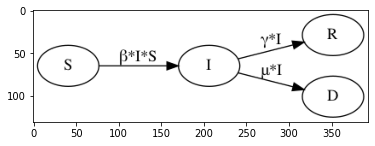

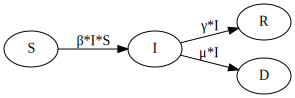

In [6]:
# display graphical representation of the model
SIR_model.get_transition_graph()

##### Derived equations, Jacobian and gradient

In [7]:
SIR_model.get_ode_eqn()

Matrix([
[                -I*S*beta],
[I*S*beta - I*gamma - I*mu],
[                  I*gamma],
[                     I*mu]])

In [8]:
SIR_model.get_jacobian_eqn()

Matrix([
[-I*beta,             -S*beta, 0, 0],
[ I*beta, S*beta - gamma - mu, 0, 0],
[      0,               gamma, 0, 0],
[      0,                  mu, 0, 0]])

In [9]:
SIR_model.get_grad_eqn()

Matrix([
[-I*S,  0,  0, 0],
[ I*S, -I, -I, 0],
[   0,  I,  0, 0],
[   0,  0,  I, 0]])

### SCIR model

#### Equations

\begin{equation}
\begin{split}
\dot{S} &= -\beta I S + c_1 S_c - c_2*S*I\\
\dot{S_c} &= - c_0 \beta I S_c - c_1 S_c + c_2*S*I\\
\dot{I} &= \beta I S - \gamma I - \mu I\\
\dot{R} & = \gamma I \\
\dot{D} & = \mu I
\end{split}
\end{equation}

The use of I as a state variable triggering susceptibles to execute caution is just one choice. In contrast with deaths, it does not accumulate over time and so retains the property of an active threat to society, rather than an historical one. Alternatively, one could use the daily death rate which is proportional to it.

Actually, the effect of caution may be quadratic, since both the individual doing the infection and individual potentially being infected may be executing caution. The current version assumes that infectives do not change their precautionary measures in response to I. To implement this we would need to further distinguish careful and non careful infectives. This is done in the SC2IR model.

#### Variables
* $S$: Susceptible individuals living as normal
* $S_c$: Susceptible individuals exercising pandemy precautions
* $I$: Infected individuals 
* $R$: individuals who have recovered from disease and are now immune
* $D$: Dead individuals
* $N=S+S_c+I+R+D$ Total population size (constant)

#### Parameters
* $\beta$ rate at which infected individuals contact susceptibles and infect them
* $\gamma$ rate at which infected individuals recover from disease and become immune
* $\mu$ death rate for infected individuals

* $c_i$ three parameters characterizing cautionary response of population via class $S_c$

    - c_0 : reduction factor for exposure for cautioned susceptibles

    - c_1 : duration of caution (exponential decay time constant in days)

    - c_2 : rate constant for transition from uncautioned to cautioned susceptible

#### Implementation
Using PyGOM, we will set up my simple SCIR model ODE system
PyGOM – A Python Package for Simplifying Modelling with Systems of Ordinary Differential Equations https://arxiv.org/pdf/1803.06934.pdf

In [10]:
# set up symbolic model

state = ['S', 'I', 'R', 'D', 'S_c']
param_list = ['beta', 'gamma', 'mu', 'c_0', 'c_1', 'c_2', 'N']

transition = [
    Transition(origin='S', destination='I', equation='beta*I*S',
               transition_type=TransitionType.T),
    Transition(origin='S', destination='S_c', equation='c_2*I*S',
               transition_type=TransitionType.T),
    Transition(origin='S_c', destination='S', equation='c_1*S_c',
               transition_type=TransitionType.T),
    Transition(origin='S_c', destination='I', equation='c_0*beta*I*S_c',
               transition_type=TransitionType.T),
    Transition(origin='I', destination='R', equation='gamma*I',
               transition_type=TransitionType.T),
    Transition(origin='I', destination='D', equation='mu*I',
               transition_type=TransitionType.T)    
    ]

SCIR_model = DeterministicOde(state, param_list, transition=transition)
SCIR_model.modelname='SCIR'
SCIR_model.ei=1
SCIR_model.confirmed=slice(1,4)  # cases 1-3 i.e. I, R and D
SCIR_model.recovered=slice(2,3)
SCIR_model.deaths=slice(3,4)

In [11]:
# display equations
print_ode2(SCIR_model)

Matrix([
[  d{S}/dt=,              -I*S*beta - I*S*c_2 + S_c*c_1],
[  d{I}/dt=, I*S*beta + I*S_c*beta*c_0 - I*gamma - I*mu],
[  d{R}/dt=,                                    I*gamma],
[  d{D}/dt=,                                       I*mu],
[d{S_c}/dt=,         I*S*c_2 - I*S_c*beta*c_0 - S_c*c_1]])

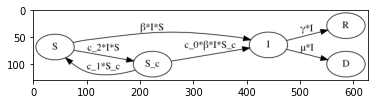

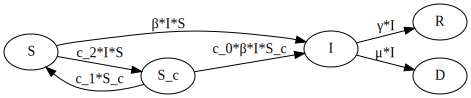

In [12]:
# display graphical representation of the model
SCIR_model.get_transition_graph()

### SC2IR model

#### Equations

\begin{equation}
\begin{split}
\dot{S} &= -\beta (I + c_0 I_c) S + c_1 S_c - c_2 S (I + I_c)\\
\dot{S_c} &= - c_0 \beta (I + c_0 I_c) S_c - c_1 S_c + c_2 S (I + I_c)\\
\dot{I} &= \beta (I + c_0 I_c) S - \gamma I - \mu I\\
\dot{I_c} &= \beta (I + c_0 I_c) S_c - \gamma I_c - \mu I_c\\
\dot{R} & = \gamma (I + I_c)\\
\dot{D} & = \mu (I + I_c)
\end{split}
\end{equation}

The use of I as a state variable triggering susceptibles to execute caution is just one choice. In contrast with deaths, it does not accumulate over time and so retains the property of an active threat to society, rather than an historical one. Alternatively, one could use the daily death rate which is proportional to it.

The effect of caution may be quadratic, since both the individual doing the infection and individual potentially being infected may be executing caution. To implement this we distinguish careful and non careful infectives. We ignore infectives making the transition to caution or relaxing it.

#### Variables
* $S$: Susceptible individuals living as normal
* $S_c$: Susceptible individuals exercising pandemy precautions
* $I$: Infected individuals non exercising pandemy precautions
* $I_c$: Infected individuals exercising pandemy precautions 
* $R$: individuals who have recovered from disease and are now immune
* $D$: Dead individuals
* $N=S+S_c+I+I_c+R+D$ Total population size (constant)

#### Parameters
* $\beta$ rate at which infected individuals contact susceptibles and infect them
* $\gamma$ rate at which infected individuals recover from disease and become immune
* $\mu$ death rate for infected individuals

* $c_i$ three parameters characterizing cautionary response of population via class $S_c$

    - c_0 : reduction factor for exposure for cautioned susceptibles

    - c_1 : duration of caution (exponential decay time constant in days)

    - c_2 : rate constant for transition from uncautioned to cautioned susceptible

#### Implementation
Using PyGOM, we will set up my simple SCIR model ODE system
PyGOM – A Python Package for Simplifying Modelling with Systems of Ordinary Differential Equations https://arxiv.org/pdf/1803.06934.pdf

In [13]:
# set up symbolic model

state = ['S', 'I', 'R', 'D', 'I_c', 'S_c']
param_list = ['beta', 'gamma', 'mu', 'c_0', 'c_1', 'c_2', 'N']

transition = [
    Transition(origin='S', destination='I', equation='beta*(I+c_0*I_c)*S',
               transition_type=TransitionType.T),
    Transition(origin='S', destination='S_c', equation='c_2*(I+I_c)*S',
               transition_type=TransitionType.T),
    Transition(origin='S_c', destination='S', equation='c_1*S_c',
               transition_type=TransitionType.T),
    Transition(origin='S_c', destination='I_c', equation='c_0*beta*(I+c_0*I_c)*S_c',
               transition_type=TransitionType.T),
    Transition(origin='I', destination='R', equation='gamma*I',
               transition_type=TransitionType.T),
    Transition(origin='I', destination='D', equation='mu*I',
               transition_type=TransitionType.T),
    Transition(origin='I_c', destination='R', equation='gamma*I_c',
               transition_type=TransitionType.T),
    Transition(origin='I_c', destination='D', equation='mu*I_c',
               transition_type=TransitionType.T)  #,
#    Transition(origin='I_c', destination='I', equation='c_1*I_c',
#               transition_type=TransitionType.T),
#    Transition(origin='I', destination='I_c', equation='c_2*(I+I_c)*I',
#               transition_type=TransitionType.T)    
    ]

SC2IR_model = DeterministicOde(state, param_list, transition=transition)
SC2IR_model.modelname='SC2IR'

SC2IR_model.ei=1
SC2IR_model.confirmed=slice(1,5)  # cases 1-3 i.e. I, R and D
SC2IR_model.recovered=slice(2,3)
SC2IR_model.deaths=slice(3,4)

In [14]:
# display equations
print_ode2(SC2IR_model)

Matrix([
[  d{S}/dt=,      -S*beta*(I + I_c*c_0) - S*c_2*(I + I_c) + S_c*c_1],
[  d{I}/dt=,                 -I*gamma - I*mu + S*beta*(I + I_c*c_0)],
[  d{R}/dt=,                                    I*gamma + I_c*gamma],
[  d{D}/dt=,                                          I*mu + I_c*mu],
[d{I_c}/dt=,       -I_c*gamma - I_c*mu + S_c*beta*c_0*(I + I_c*c_0)],
[d{S_c}/dt=, S*c_2*(I + I_c) - S_c*beta*c_0*(I + I_c*c_0) - S_c*c_1]])


\begin{equation}
\begin{split}
\dot{S} &= -\beta (I + c_0 I_c) S + c_1 S_c - c_2 S (I + I_c)\\
\dot{S_c} &= - c_0 \beta (I + c_0 I_c) S_c - c_1 S_c + c_2 S (I + I_c)\\
\dot{I} &= \beta (I + c_0 I_c) S - \gamma I - \mu I\\
\dot{I_c} &= \beta (I + c_0 I_c) S_c - \gamma I_c - \mu I_c\\
\dot{R} & = \gamma (I + I_c)\\
\dot{D} & = \mu (I + I_c)
\end{split}
\end{equation}


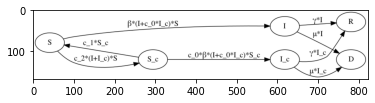

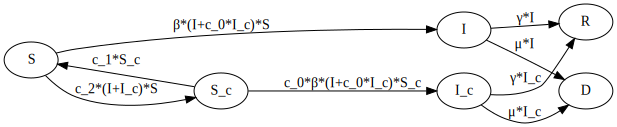

In [15]:
# display graphical representation of the model
SC2IR_model.get_transition_graph()

## Caution Extensions to SEIR Model

### SEIR model

#### Equations

\begin{equation}
\begin{split}
\dot{S} &= -\beta I S\\
\dot{E} &= \beta I S - \alpha E\\
\dot{I} &= \alpha E - \gamma I - \mu I\\
\dot{R} & = \gamma I \\
\dot{D} & = \mu I
\end{split}
\end{equation}


#### Variables
* $S$: Susceptible individuals
* $E$: Exposed individuals
* $I$: Infected individuals 
* $R$: individuals who have recovered from disease and are now immune
* $D$: Dead individuals
* $N=S+E+I+R+D$ Total population size (constant)

#### Parameters
* $\beta$ rate at which infected individuals contact susceptibles and expose them to infection
* $\alpha$ rate at which exposed individuals become infected (1/(incubation time)
* $\gamma$ rate at which infected individuals recover from disease and become immune
* $\mu$ death rate for infected individuals

#### Implementation
Using PyGOM, we will set up my simple SCIR model ODE system
PyGOM – A Python Package for Simplifying Modelling with Systems of Ordinary Differential Equations https://arxiv.org/pdf/1803.06934.pdf

In [16]:
# set up the symbolic model
state = ['S', 'E', 'I', 'R', 'D']
param_list = ['beta', 'alpha', 'gamma', 'mu', 'N']

transition = [
    Transition(origin='S', destination='E', equation='beta*I*S',
               transition_type=TransitionType.T),
    Transition(origin='E', destination='I', equation='alpha*E',
               transition_type=TransitionType.T),
    Transition(origin='I', destination='R', equation='gamma*I',
               transition_type=TransitionType.T),
    Transition(origin='I', destination='D', equation='mu*I',
               transition_type=TransitionType.T)    
    ]

SEIR_model = DeterministicOde(state, param_list, transition=transition)
SEIR_model.modelname='SEIR'
SEIR_model.ei=slice(1,3) # cases 1,2 i.e. E and I
SEIR_model.confirmed=slice(2,5)  # cases 2-4 i.e. I, R and D, not E
SEIR_model.recovered=slice(3,4)
SEIR_model.deaths=slice(4,5)


In [17]:
# display equations
print_ode2(SEIR_model)

Matrix([
[d{S}/dt=,                -I*S*beta],
[d{E}/dt=,      -E*alpha + I*S*beta],
[d{I}/dt=, E*alpha - I*gamma - I*mu],
[d{R}/dt=,                  I*gamma],
[d{D}/dt=,                     I*mu]])

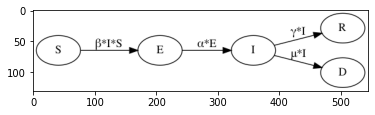

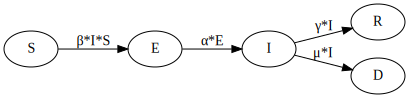

In [18]:
# display graphical representation of the model
SEIR_model.get_transition_graph()

### SCEIR model

#### Equations

\begin{equation}
\begin{split}
\dot{S} &= -\beta I S + c_1 S_c - c_2*S*I\\
\dot{S_c} &= - c_0 \beta I S_c - c_1 S_c + c_2*S*I\\
\dot{E} &= \beta I (S + c_0 S_c) - \alpha E\\
\dot{I} &= \alpha E - \gamma I - \mu I\\
\dot{R} & = \gamma I \\
\dot{D} & = \mu I
\end{split}
\end{equation}

The use of I as a state variable triggering susceptibles to execute caution is just one choice. In contrast with deaths, it does not accumulate over time and so retains the property of an active threat to society, rather than an historical one. Alternatively, one could use the daily death rate which is proportional to it.

Actually, the effect of caution may be quadratic, since both the individual doing the infection and individual potentially being infected may be executing caution. The current version assumes that infectives do not change their precautionary measures in response to I. To implement this we would need to further distinguish careful and non careful infectives. This is done in the SC2IR model.

#### Variables
* $S$: Susceptible individuals living as normal
* $S_c$: Susceptible individuals exercising pandemy precautions
* $E$: Exposed individuals
* $I$: Infected individuals 
* $R$: individuals who have recovered from disease and are now immune
* $D$: Dead individuals
* $N=S+S_c+E+I+R+D$ Total population size (constant)

#### Parameters
* $\beta$ rate at which infected individuals contact susceptibles and infect them
* $\alpha$ rate at which exposed individuals become infected (1/(incubation time)
* $\gamma$ rate at which infected individuals recover from disease and become immune
* $\mu$ death rate for infected individuals

* $c_i$ three parameters characterizing cautionary response of population via class $S_c$

    - c_0 : reduction factor for exposure for cautioned susceptibles

    - c_1 : duration of caution (exponential decay time constant in days)

    - c_2 : rate constant for transition from uncautioned to cautioned susceptible

#### Implementation
Using PyGOM, we will set up my simple SCIR model ODE system
PyGOM – A Python Package for Simplifying Modelling with Systems of Ordinary Differential Equations https://arxiv.org/pdf/1803.06934.pdf

In [19]:
# set up the symbolic model

state = ['S', 'E', 'I', 'R', 'D', 'S_c']
param_list = ['beta', 'alpha', 'gamma', 'mu', 'c_0', 'c_1', 'c_2', 'N']

transition = [
    Transition(origin='S', destination='E', equation='beta*I*S',
               transition_type=TransitionType.T),
    Transition(origin='S', destination='S_c', equation='c_2*I*S',
               transition_type=TransitionType.T),
    Transition(origin='S_c', destination='S', equation='c_1*S_c',
               transition_type=TransitionType.T),
    Transition(origin='S_c', destination='E', equation='c_0*beta*I*S_c',
               transition_type=TransitionType.T),
    Transition(origin='E', destination='I', equation='alpha*E',
               transition_type=TransitionType.T),
    Transition(origin='I', destination='R', equation='gamma*I',
               transition_type=TransitionType.T),
    Transition(origin='I', destination='D', equation='mu*I',
               transition_type=TransitionType.T)    
    ]

SCEIR_model = DeterministicOde(state, param_list, transition=transition)
SCEIR_model.modelname='SCEIR'
SCEIR_model.ei=slice(1,3) # cases 1,2 i.e. E,I
SCEIR_model.confirmed=slice(2,5)  # cases 2-4 i.e. I, R and D, not E
SCEIR_model.recovered=slice(3,4)
SCEIR_model.deaths=slice(4,5)

In [20]:
# display equations
print_ode2(SCEIR_model)

Matrix([
[  d{S}/dt=,        -I*S*beta - I*S*c_2 + S_c*c_1],
[  d{E}/dt=, -E*alpha + I*S*beta + I*S_c*beta*c_0],
[  d{I}/dt=,             E*alpha - I*gamma - I*mu],
[  d{R}/dt=,                              I*gamma],
[  d{D}/dt=,                                 I*mu],
[d{S_c}/dt=,   I*S*c_2 - I*S_c*beta*c_0 - S_c*c_1]])

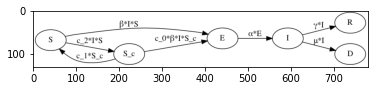

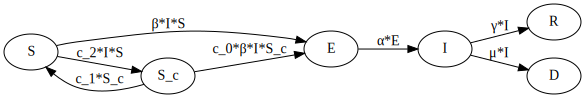

In [21]:
# display graphical representation of the model
SCEIR_model.get_transition_graph()

### SC3EIR model

#### Equations

\begin{equation}
\begin{split}
\dot{S} &= -\beta (I + c_0 I_c) S + c_1 S_c - c_2 S (I + I_c)\\
\dot{S_c} &= - c_0 \beta (I + c_0 I_c) S_c - c_1 S_c + c_2 S (I + I_c)\\
\dot{E} &= \beta I S - \alpha E\\
\dot{E_c} &= c_0 \beta I S_c) - \alpha E_c\\
\dot{I} &= \alpha E - \gamma I - \mu I\\
\dot{I_c} &= \alpha E_c - \gamma I_c - \mu I_c\\
\dot{R} & = \gamma (I + I_c) \\
\dot{D} & = \mu (I + I_c)
\end{split}
\end{equation}

The use of I as a state variable triggering susceptibles to execute caution is just one choice. In contrast with deaths, it does not accumulate over time and so retains the property of an active threat to society, rather than an historical one. Alternatively, one could use the daily death rate which is proportional to it.

Actually, the effect of caution may be quadratic, since both the individual doing the infection and individual potentially being infected may be executing caution. The current version assumes that infectives do not change their precautionary measures in response to I. To implement this we would need to further distinguish careful and non careful infectives. This is done in the SC2IR model.

#### Variables
* $S$: Susceptible individuals living as normal
* $S_c$: Susceptible individuals exercising pandemy precautions
* $E$: Exposed individuals
* $E_c$: Exposed individuals exercising caution
* $I$: Infected individuals
* $I_c$: Infected individuals exercising caution
* $R$: individuals who have recovered from disease and are now immune
* $D$: Dead individuals
* $N=S+S_c+E+E_c+I+I_c+R+D$ Total population size (constant)

#### Parameters
* $\beta$ rate at which infected individuals contact susceptibles and infect them
* $\alpha$ rate at which exposed individuals become infected (1/(incubation time)
* $\gamma$ rate at which infected individuals recover from disease and become immune
* $\mu$ death rate for infected individuals

* $c_i$ three parameters characterizing cautionary response of population via class $S_c$

    - c_0 : reduction factor for exposure for cautioned susceptibles

    - c_1 : duration of caution (exponential decay time constant in days)

    - c_2 : rate constant for transition from uncautioned to cautioned susceptible

#### Implementation
Using PyGOM, we will set up my simple SCIR model ODE system
PyGOM – A Python Package for Simplifying Modelling with Systems of Ordinary Differential Equations https://arxiv.org/pdf/1803.06934.pdf

In [22]:
# set up the symbolic model

state = ['S', 'E', 'I', 'R', 'D', 'I_c', 'S_c', 'E_c']
param_list = ['beta', 'alpha', 'gamma', 'mu', 'c_0', 'c_1', 'c_2', 'N']

transition = [
    Transition(origin='S', destination='E', equation='beta*(I+c_0*I_c)*S',
               transition_type=TransitionType.T),
    Transition(origin='S', destination='S_c', equation='c_2*I*S',
               transition_type=TransitionType.T),
    Transition(origin='S_c', destination='S', equation='c_1*S_c',
               transition_type=TransitionType.T),
    Transition(origin='S_c', destination='E_c', equation='c_0*beta*(I+c_0*I_c)*S_c',
               transition_type=TransitionType.T),
    Transition(origin='E', destination='I', equation='alpha*E',
               transition_type=TransitionType.T),
    Transition(origin='E_c', destination='I_c', equation='alpha*E_c',
               transition_type=TransitionType.T),
    Transition(origin='I', destination='R', equation='gamma*I',
               transition_type=TransitionType.T),
    Transition(origin='I_c', destination='R', equation='gamma*I_c',
               transition_type=TransitionType.T),
    Transition(origin='I', destination='D', equation='mu*I',
               transition_type=TransitionType.T),
    Transition(origin='I_c', destination='D', equation='mu*I_c',
               transition_type=TransitionType.T)
    ]

SC3EIR_model = DeterministicOde(state, param_list, transition=transition)
SC3EIR_model.modelname='SC3EIR'
SC3EIR_model.ei=slice(1,3) # cases 1,2 i.e. E,I  # note E_c and I_c not included
SC3EIR_model.confirmed=slice(2,6)  # cases 2-5 i.e. I, R, D, and I_c, not E, E_c
SC3EIR_model.recovered=slice(3,4)
SC3EIR_model.deaths=slice(4,5)

In [23]:
# display equations
print_ode2(SC3EIR_model)

Matrix([
[  d{S}/dt=,      -I*S*c_2 - S*beta*(I + I_c*c_0) + S_c*c_1],
[  d{E}/dt=,                -E*alpha + S*beta*(I + I_c*c_0)],
[  d{I}/dt=,                       E*alpha - I*gamma - I*mu],
[  d{R}/dt=,                            I*gamma + I_c*gamma],
[  d{D}/dt=,                                  I*mu + I_c*mu],
[d{I_c}/dt=,                 E_c*alpha - I_c*gamma - I_c*mu],
[d{S_c}/dt=, I*S*c_2 - S_c*beta*c_0*(I + I_c*c_0) - S_c*c_1],
[d{E_c}/dt=,        -E_c*alpha + S_c*beta*c_0*(I + I_c*c_0)]])

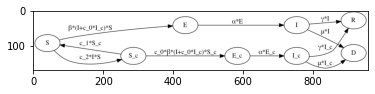

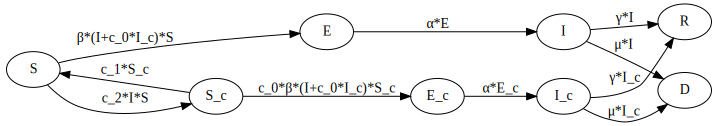

In [24]:
# display graphical representation of the model
SC3EIR_model.get_transition_graph()

## Caution Extensions to SEI3R Model

### SEI3R model

#### Equations

\begin{equation}
\begin{split}
\dot{S} &= -(\beta_1 I_1 +\beta_2 I_2 + \beta_3 I_3) S\\
\dot{E} &=(\beta_1 I_1 +\beta_2 I_2 + \beta_3 I_3 ) S - a E \\
\dot{I_1} &= a E - \gamma_1 I_1 - p_1 I_1 \\
\dot{I_2} &= p_1 I_1 -\gamma_2 I_2 - p_2 I_2 \\
\dot{I_3} & = p_2 I_2 -\gamma_3 I_3 - \mu I_3 \\
\dot{R} & = \gamma_1 I_1 + \gamma_2 I_2 + \gamma_3 I_3 \\
\dot{D} & = \mu I_3
\end{split}
\end{equation}

This model (by Dr. Alison for example) involves exposed but not infectious individuals and three classes of infective states with increasing severity.
The latter two involve hospitalization with the last in ICU.

#### Variables
* $S$: Susceptible individuals living as normal
* $E$: Exposed individuals - infected but not yet infectious or symptomatic
* $I_i$: Infected individuals in severity class $i$. Severity increaes with $i$ and we assume individuals must pass through all previous classes
  * $I_1$: Mild infection (hospitalization not required)
  * $I_2$: Severe infection (hospitalization required)
  * $I_3$: Critical infection (ICU required)
* $R$: individuals who have recovered from disease and are now immune
* $D$: Dead individuals
* $N=S+E+I_1+I_2+I_3+R+D$ Total population size (constant)

#### Parameters
* $\beta_i$ rate at which infected individuals in class $I_i$ contact susceptibles and infect them
* $a$ rate of progression from the exposed to infected class
* $\gamma_i$ rate at which infected individuals in class $I_i$ recover from disease and become immune
* $p_i$ rate at which infected individuals in class $I_i$ progress to class $I_{I+1}$
* $\mu$ death rate for individuals in the most severe stage of disease

#### Implementation
Using PyGOM, we will set up the model ODE system
PyGOM – A Python Package for Simplifying Modelling with Systems of Ordinary Differential Equations https://arxiv.org/pdf/1803.06934.pdf

In [25]:
# set up the symbolic SEI3R model

state = ['S', 'E', 'I_1', 'I_2','I_3','R','D']
param_list = ['beta_1', 'beta_2','beta_3','alpha', 'gamma_1', 'gamma_2', 'gamma_3',
              'p_1','p_2','mu','N']

transition = [
    Transition(origin='S', destination='E', equation='(beta_1*I_1+beta_2*I_2+beta_3*I_3)*S',
               transition_type=TransitionType.T),
    Transition(origin='E', destination='I_1', equation='alpha*E',
               transition_type=TransitionType.T),
    Transition(origin='I_1', destination='R', equation='gamma_1*I_1',
               transition_type=TransitionType.T),
    Transition(origin='I_2', destination='R', equation='gamma_2*I_2',
               transition_type=TransitionType.T),
    Transition(origin='I_3', destination='R', equation='gamma_3*I_3',
               transition_type=TransitionType.T),
    Transition(origin='I_1', destination='I_2', equation='p_1*I_1',
               transition_type=TransitionType.T),
    Transition(origin='I_2', destination='I_3', equation='p_2*I_2',
               transition_type=TransitionType.T),
    Transition(origin='I_3', destination='D', equation='mu*I_3',
               transition_type=TransitionType.T)    
    ]


SEI3R_model = DeterministicOde(state, param_list, transition=transition)
SEI3R_model.modelname='SEI3R'
SEI3R_model.ei=slice(1,5)
SEI3R_model.confirmed=slice(2,7)  # cases 2-6 i.e. I1, I2, I3, R and D
SEI3R_model.recovered=slice(5,6)
SEI3R_model.deaths=slice(6,7)

In [26]:
# display equations
print_ode2(SEI3R_model)

Matrix([
[  d{S}/dt=,           -S*(I_1*beta_1 + I_2*beta_2 + I_3*beta_3)],
[  d{E}/dt=, -E*alpha + S*(I_1*beta_1 + I_2*beta_2 + I_3*beta_3)],
[d{I_1}/dt=,                     E*alpha - I_1*gamma_1 - I_1*p_1],
[d{I_2}/dt=,                     I_1*p_1 - I_2*gamma_2 - I_2*p_2],
[d{I_3}/dt=,                      I_2*p_2 - I_3*gamma_3 - I_3*mu],
[  d{R}/dt=,             I_1*gamma_1 + I_2*gamma_2 + I_3*gamma_3],
[  d{D}/dt=,                                              I_3*mu]])

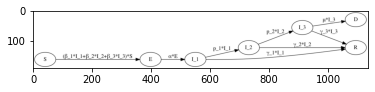

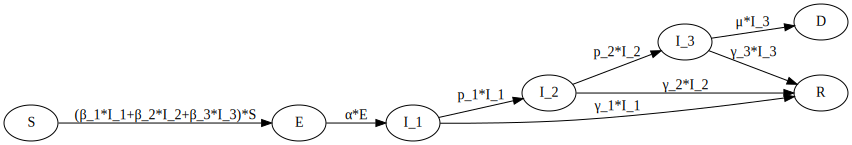

In [27]:
# display graphical representation of the model
SEI3R_model.get_transition_graph()

### SCEI3R model

#### Equations

\begin{equation}
\begin{split}
\dot{S} &= -(\beta_1 I_1 +\beta_2 I_2 + \beta_3 I_3) S + c_1 S_c - c_2*S*I_3\\
\dot{S_c} &= - c_0(\beta_1 I_1 +\beta_2 I_2 + \beta_3 I_3) S_c - c_1 S_c + c_2*S*I_3\\
\dot{E} &=(\beta_1 I_1 +\beta_2 I_2 + \beta_3 I_3 ) (S + c_0 S_c) - a E \\
\dot{I_1} &= a E - \gamma_1 I_1 - p_1 I_1 \\
\dot{I_2} &= p_1 I_1 -\gamma_2 I_2 - p_2 I_2 \\
\dot{I_3} & = p_2 I_2 -\gamma_3 I_3 - \mu I_3 \\
\dot{R} & = \gamma_1 I_1 + \gamma_2 I_2 + \gamma_3 I_3 \\
\dot{D} & = \mu I_3
\end{split}
\end{equation}

The use of I_3 as a state variable triggering susceptibles to execute caution is just one choice. In contrast with deaths, it does not accumulate over time and so retains the property of an active threat to society, rather than an historical one.

Actually, the effect of caution may be quadratic, since both the individual doing the infection and individual potentially being infected may be executing caution. The current version assumes that infectives do not change their precautionary measures in response to I_3. To implement this we would need to further distinguish careful and non careful infectives at least up to the I_1 level. This is done in the SC3EI3R model.

#### Variables
* $S$: Susceptible individuals living as normal
* $S_c$: Susceptible individuals exercising pandemy precautions
* $E$: Exposed individuals - infected but not yet infectious or symptomatic
* $I_i$: Infected individuals in severity class $i$. Severity increaes with $i$ and we assume individuals must pass through all previous classes
  * $I_1$: Mild infection (hospitalization not required)
  * $I_2$: Severe infection (hospitalization required)
  * $I_3$: Critical infection (ICU required)
* $R$: individuals who have recovered from disease and are now immune
* $D$: Dead individuals
* $N=S+S_c+E+I_1+I_2+I_3+R+D$ Total population size (constant)

#### Parameters
* $\beta_i$ rate at which infected individuals in class $I_i$ contact susceptibles and infect them
* $a$ rate of progression from the exposed to infected class
* $\gamma_i$ rate at which infected individuals in class $I_i$ recover from disease and become immune
* $p_i$ rate at which infected individuals in class $I_i$ progress to class $I_{I+1}$
* $\mu$ death rate for individuals in the most severe stage of disease

* $c_i$ three parameters characterizing cautionary response of population via class $S_c$

    - c_0 : reduction factor for exposure for cautioned susceptibles

    - c_1 : duration of caution (exponential decay time constant in days)

    - c_2 : rate constant for transition from uncautioned to cautioned susceptible




#### Implementation
Using PyGOM, we will set up the model ODE system
PyGOM – A Python Package for Simplifying Modelling with Systems of Ordinary Differential Equations https://arxiv.org/pdf/1803.06934.pdf

In [28]:
# set up the symbolic model

state = ['S', 'E', 'I_1', 'I_2','I_3','R','D','S_c']
param_list = ['beta_1', 'beta_2','beta_3','alpha', 'gamma_1', 'gamma_2', 'gamma_3',
              'p_1','p_2','mu','c_0','c_1','c_2','N']

transition = [
    Transition(origin='S', destination='E', equation='(beta_1*I_1+beta_2*I_2+beta_3*I_3)*S',
               transition_type=TransitionType.T),
    Transition(origin='S', destination='S_c', equation='c_2*I_3*S',
               transition_type=TransitionType.T),
    Transition(origin='S_c', destination='S', equation='c_1*S_c',
               transition_type=TransitionType.T),
    Transition(origin='S_c', destination='E', equation='c_0*(beta_1*I_1+beta_2*I_2+beta_3*I_3)*S_c',
               transition_type=TransitionType.T),
    Transition(origin='E', destination='I_1', equation='alpha*E',
               transition_type=TransitionType.T),
    Transition(origin='I_1', destination='R', equation='gamma_1*I_1',
               transition_type=TransitionType.T),
    Transition(origin='I_2', destination='R', equation='gamma_2*I_2',
               transition_type=TransitionType.T),
    Transition(origin='I_3', destination='R', equation='gamma_3*I_3',
               transition_type=TransitionType.T),
    Transition(origin='I_1', destination='I_2', equation='p_1*I_1',
               transition_type=TransitionType.T),
    Transition(origin='I_2', destination='I_3', equation='p_2*I_2',
               transition_type=TransitionType.T),
    Transition(origin='I_3', destination='D', equation='mu*I_3',
               transition_type=TransitionType.T)    
    ]


SCEI3R_model = DeterministicOde(state, param_list, transition=transition)
SCEI3R_model.modelname='SCEI3R'
SCEI3R_model.ei=slice(1,5)
SCEI3R_model.confirmed=slice(2,7)  # cases 2-6 i.e. I1, I2, I3, R and D
SCEI3R_model.recovered=slice(5,6)
SCEI3R_model.deaths=slice(6,7)

In [29]:
# display equations
print_ode2(SCEI3R_model)

Matrix([
[  d{S}/dt=,                                      -I_3*S*c_2 - S*(I_1*beta_1 + I_2*beta_2 + I_3*beta_3) + S_c*c_1],
[  d{E}/dt=, -E*alpha + S*(I_1*beta_1 + I_2*beta_2 + I_3*beta_3) + S_c*c_0*(I_1*beta_1 + I_2*beta_2 + I_3*beta_3)],
[d{I_1}/dt=,                                                                      E*alpha - I_1*gamma_1 - I_1*p_1],
[d{I_2}/dt=,                                                                      I_1*p_1 - I_2*gamma_2 - I_2*p_2],
[d{I_3}/dt=,                                                                       I_2*p_2 - I_3*gamma_3 - I_3*mu],
[  d{R}/dt=,                                                              I_1*gamma_1 + I_2*gamma_2 + I_3*gamma_3],
[  d{D}/dt=,                                                                                               I_3*mu],
[d{S_c}/dt=,                                 I_3*S*c_2 - S_c*c_0*(I_1*beta_1 + I_2*beta_2 + I_3*beta_3) - S_c*c_1]])

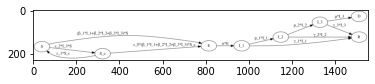

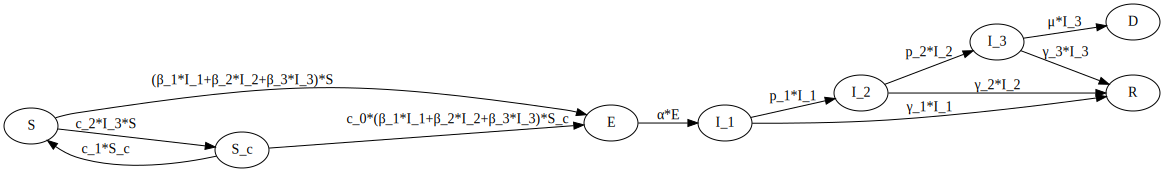

In [30]:
# display graphical representation of the model
SCEI3R_model.get_transition_graph()

### SC3EI3R model with caution distinguished $E$ and  𝐼1

#### Equations

\begin{equation}
\begin{split}
\dot{S} &= -(\beta_1 (I_1 + c_0 I_{1c}) +\beta_2 I_2 + \beta_3 I_3) S + c_1 S_c - c_2*S*I_3\\
\dot{S_c} &= - c_0(\beta_1 (I_1 + c_0 I_{1c}) +\beta_2 I_2 + \beta_3 I_3) S_c - c_1 S_c + c_2*S*I_3\\
\dot{E} &=(\beta_1 (I_1 + c_0 I_{1c}) +\beta_2 I_2 + \beta_3 I_3 ) S - a E \\
\dot{E_c} &=(\beta_1 (I_1 + c_0 I_{1c}) +\beta_2 I_2 + \beta_3 I_3 ) c_0 S_c - a E \\
\dot{I_1} &= a E - \gamma_1 I_1 - p_1 I_1 \\
\dot{I_{1c}} &= a E_c - \gamma_1 I_{1c} - p_1 I_{1c} \\
\dot{I_2} &= p_1 (I_1 + I_{1c}) -\gamma_2 I_2 - p_2 I_2 \\
\dot{I_3} & = p_2 I_2 -\gamma_3 I_3 - \mu I_3 \\
\dot{R} & = \gamma_1 (I_1 + I_{1c}) + \gamma_2 I_2 + \gamma_3 I_3 \\
\dot{D} & = \mu I_3
\end{split}
\end{equation}

The use of I_3 as a state variable triggering susceptibles to execute caution is just one choice. In contrast with deaths, it does not accumulate over time and so retains the property of an active threat to society, rather than an historical one.

Here, the effect of caution is quadratic, since both the individual doing the infection and individual potentially being infected may be executing caution. To implement this we distinguish careful and non careful exposed and infectives up to the I_1 level. Once in hospital there is no difference, since all caution is executed wrt infected patients.
We ignore transition in caution among infected intervals as a second order effect: could be included as in SC2IR model.


#### Variables
* $S$: Susceptible individuals living as normal
* $S_c$: Susceptible individuals exercising pandemy precautions
* $E$: Exposed individuals living as normal - infected but not yet infectious or symptomatic
* $E_c$: Exposed individuals exercising pandemy precautions
* $I_i$: Infected individuals in severity class $i$. Severity increaes with $i$ and we assume individuals must pass through all previous classes. Split non hospital cases by caution.
  * $I_1$: Mild infection (hospitalization not required), living as normal
  * $I_{1c}$: Mild infection (hospitalization not required), exercising caution
  * $I_2$: Severe infection (hospitalization required)
  * $I_3$: Critical infection (ICU required)
* $R$: individuals who have recovered from disease and are now immune
* $D$: Dead individuals
* $N=S+S_c+E+E_c+I_{1c}+I_1+I_2+I_3+R+D$ Total population size (constant)

#### Parameters
* $\beta_i$ rate at which infected individuals in class $I_i$ contact susceptibles and infect them
* $a$ rate of progression from the exposed to infected class
* $\gamma_i$ rate at which infected individuals in class $I_i$ recover from disease and become immune
* $p_i$ rate at which infected individuals in class $I_i$ progress to class $I_{I+1}$
* $\mu$ death rate for individuals in the most severe stage of disease

* $c_i$ three parameters characterizing cautionary response of population via class $S_c$

    - c_0 : reduction factor for exposure for cautioned susceptibles

    - c_1 : duration of caution (exponential decay time constant in days)

    - c_2 : rate constant for transition from uncautioned to cautioned susceptible

####  Implementation

In [31]:
# set up the symbolic model

state = ['S', 'E', 'I_1', 'I_2','I_3', 'R', 'D', 'I_c', 'S_c', 'E_c']
param_list = ['beta_1', 'beta_2','beta_3','alpha', 'gamma_1', 'gamma_2', 'gamma_3',
              'p_1','p_2','mu','c_0','c_1','c_2','N']

transition = [
    Transition(origin='S', destination='E', equation='(beta_1*I_1+beta_2*I_2+beta_3*I_3+c_0*beta_1*I_c)*S',
               transition_type=TransitionType.T),
    Transition(origin='S_c', destination='E_c', equation='c_0*(beta_1*I_1+beta_2*I_2+beta_3*I_3+c_0*beta_1*I_c)*S_c',
               transition_type=TransitionType.T),
    Transition(origin='S', destination='S_c', equation='c_2*I_3*S',
               transition_type=TransitionType.T),
    Transition(origin='S_c', destination='S', equation='c_1*S_c',
               transition_type=TransitionType.T),
    Transition(origin='E', destination='I_1', equation='alpha*E',
               transition_type=TransitionType.T),
    Transition(origin='E_c', destination='I_c', equation='alpha*E_c',
               transition_type=TransitionType.T),
    Transition(origin='I_1', destination='R', equation='gamma_1*I_1',
               transition_type=TransitionType.T),
    Transition(origin='I_c', destination='R', equation='gamma_1*I_c',
               transition_type=TransitionType.T),
    Transition(origin='I_2', destination='R', equation='gamma_2*I_2',
               transition_type=TransitionType.T),
    Transition(origin='I_3', destination='R', equation='gamma_3*I_3',
               transition_type=TransitionType.T),
    Transition(origin='I_1', destination='I_2', equation='p_1*I_1',
               transition_type=TransitionType.T),
    Transition(origin='I_c', destination='I_2', equation='p_1*I_c',
               transition_type=TransitionType.T),
    Transition(origin='I_2', destination='I_3', equation='p_2*I_2',
               transition_type=TransitionType.T),
    Transition(origin='I_3', destination='D', equation='mu*I_3',
               transition_type=TransitionType.T)    
    ]


SC3EI3R_model = DeterministicOde(state, param_list, transition=transition)
SC3EI3R_model.modelname='SC3EI3R'
SC3EI3R_model.ei=slice(1,5) # 1,2,3,4 i.e. E,I_1,I_2,I_3 – not E_c and I_c 
SC3EI3R_model.confirmed=slice(2,8)  # cases 2-7 i.e. I1, I2, I3, R, D and I_c
SC3EI3R_model.recovered=slice(5,6)
SC3EI3R_model.deaths=slice(6,7)

In [32]:
# display equations
print_ode2(SC3EI3R_model)

Matrix([
[  d{S}/dt=,      -I_3*S*c_2 - S*(I_1*beta_1 + I_2*beta_2 + I_3*beta_3 + I_c*beta_1*c_0) + S_c*c_1],
[  d{E}/dt=,                  -E*alpha + S*(I_1*beta_1 + I_2*beta_2 + I_3*beta_3 + I_c*beta_1*c_0)],
[d{I_1}/dt=,                                                       E*alpha - I_1*gamma_1 - I_1*p_1],
[d{I_2}/dt=,                                             I_1*p_1 - I_2*gamma_2 - I_2*p_2 + I_c*p_1],
[d{I_3}/dt=,                                                        I_2*p_2 - I_3*gamma_3 - I_3*mu],
[  d{R}/dt=,                                 I_1*gamma_1 + I_2*gamma_2 + I_3*gamma_3 + I_c*gamma_1],
[  d{D}/dt=,                                                                                I_3*mu],
[d{I_c}/dt=,                                                     E_c*alpha - I_c*gamma_1 - I_c*p_1],
[d{S_c}/dt=, I_3*S*c_2 - S_c*c_0*(I_1*beta_1 + I_2*beta_2 + I_3*beta_3 + I_c*beta_1*c_0) - S_c*c_1],
[d{E_c}/dt=,          -E_c*alpha + S_c*c_0*(I_1*beta_1 + I_2*beta_2 + I_3*beta_3 +

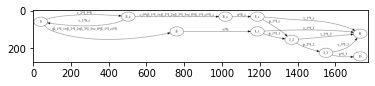

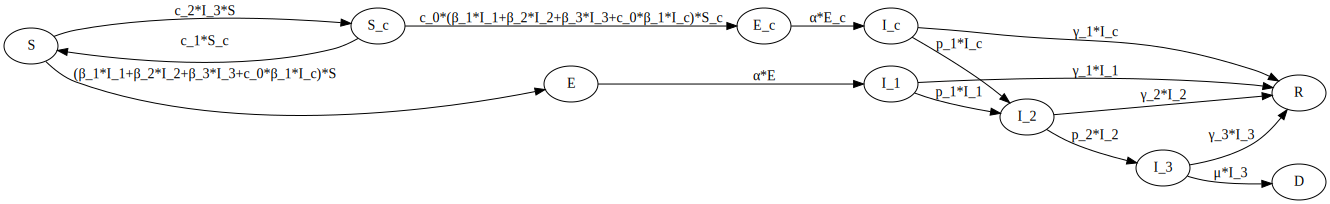

In [33]:
# display graphical representation of the model
SC3EI3R_model.get_transition_graph()

# Extract data from Johns Hopkins data base

## Definition of data extraction fuctions get_data and get_country_data

In [34]:
import numpy as np
import csv
import itertools
import matplotlib
%matplotlib inline
import seaborn as sb
from matplotlib import pyplot as plt
from cycler import cycler
import datetime
import matplotlib.dates as mdates
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import pwlf
import sys
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [35]:
def get_data(jhu_file):
    dat = []
    with open(jhu_file, newline='') as csvfile:
        myreader = csv.reader(csvfile, delimiter=',')
        popdat = []
        i = 0
        for row in myreader:
            if i != 0:
                poplist = []
                j = 0
                for elt in row:
                    if j >= 4:
                        poplist.append(int(elt))
                    elif j == 0:
                        poplist.append(elt)
                    elif j == 1:
                        poplist[0]=(elt,poplist[0])
                    j = j+1
                popdat.append(poplist)
            else:
                popdat.append(row)
            # print(popdat[i])
            i = i + 1;
    # dates
    popdat0=['dates']
    for elt in popdat[0][4:]:
        popdat0.append(elt)
    popdat[0] = [pop for pop in popdat0]
    # print('popdat[0]',popdat[0])
    # totals over all countries
    totals = np.zeros(len(popdat[0])-1,dtype=int)
    for row in popdat[1:]:
        totals = totals + np.array(row[1:])
    totals = list(np.asarray(totals))
    # print(totals)
    popkeyed = {poplist[0]: poplist[1:] for poplist in popdat}
    popkeyed.update({'dates':popdat[0][1:]})
    popkeyed.update({('World',''):totals})
    # del popkeyed[('d','a')]
    # assemble totals for countries with multiple regions
    total = np.zeros(len(popkeyed['dates']),dtype=int)
    poptotkeyed = {}
    for country,tseries in popkeyed.items():
        if country!='dates' and country[1] != '': # it seems that UK is single exception with both '' and non '' regions, UK total is then UK overseas
            countrytotal = (country[0],'Total')
            if countrytotal in poptotkeyed:
                # print(country,popkeyed[country],poptotkeyed[countrytotal])
                total = np.array(tseries)[:]+np.array(poptotkeyed[countrytotal])[:]
            else:
                total =  np.array(tseries)                        
            poptotkeyed.update({countrytotal:list(total)})
    for countrytotal,tseries in poptotkeyed.items():
        total = np.array(tseries)
        popkeyed.update({countrytotal:list(total)})
    return popkeyed

In [36]:
def Float(x):
    try:
        rtn = float(x)
    except:
        rtn = float('NaN')
    return rtn

In [37]:
 def get_country_data(country_s='World', datatype='confirmed', firstdate=None, lastdate=None):
    if isinstance(country_s,str):
        country = (country_s,'')
    else:                               # single ('country','reg') entry
        country = country_s
    popkeyed = covid_ts[datatype]
    
    dates = popkeyed['dates']
    fmt = '%m/%d/%y'
    xx = [datetime.datetime.strptime(dd,fmt) for dd in dates ]
    if firstdate:
        firstdate_d = datetime.datetime.strptime(firstdate,fmt)
    else:
        firstdate_d = datetime.datetime.strptime(dates[0],fmt)
    if lastdate:
        lastdate_d = datetime.datetime.strptime(lastdate,fmt)
    else:
        lastdate_d = datetime.datetime.strptime(dates[-1],fmt)    
    daystart = (firstdate_d-xx[0]).days
    daystop = (lastdate_d-xx[-1]).days

    try:
        yy = popkeyed[country]
        # print(country)
    except:
            print('country data not found',country)
            return None,None      
    yyf = [Float(y) for y in yy]

    yy0 = []
    yy1 = []  
    if daystart>len(yyf):
        print('Error: start date does not overlap with available data')
        return None,None
    elif daystart>0:
        yyf = yyf[daystart:]
    elif daystart <0:
        yy0 = [0.]*(-daystart)
        
    if daystop < 0:
        yyf = yyf[:daystop]  
    elif daystop > 0:
        yy1 = [0.]*(daystop)
    yyf = yy0 + yyf + yy1
    xxf = [float(x) for x in range(len(yyf))]
    return xxf,yyf 

## JHU data

In [38]:
base = '../../covid-19-JH/csse_covid_19_data/csse_covid_19_time_series/'
confirmed = get_data(base+'time_series_covid19_confirmed_global.csv')
deaths = get_data(base+'time_series_covid19_deaths_global.csv')
recovered = get_data(base+'time_series_covid19_recovered_global.csv')
covid_ts = {'confirmed':confirmed,'deaths':deaths,'recovered':recovered}
countries_jhu = [(row[0],row[1]) for row in confirmed][1:]
print("number of countries listed",len(countries_jhu))
i=0
for country in countries_jhu:
#    print(i,country)
    i = i + 1

number of countries listed 274


## Get data for one country

In [120]:
# assumed data starting on firstdate
test_country='Germany'
N = 60000000
firstdate = '01/25/20'
lastdate = '06/07/20'
xxf,yy0 = get_country_data(test_country,'confirmed',firstdate=firstdate,lastdate=lastdate)
xxf,yy1 = get_country_data(test_country,'recovered',firstdate=firstdate,lastdate=lastdate)
xxf,yy2 = get_country_data(test_country,'deaths',firstdate=firstdate,lastdate=lastdate)
# print(xxf)
y_jhu={}
y_jhu[test_country] = np.array([[yy0[i],yy1[i],yy2[i]] for i in range(0,len(yy0))])/N
# data = np.array([[xxf[i],yy0[i],yy1[i],yy2[i]] for i in range(len(yy))])
# print(data)
lastday = len(y_jhu[test_country])
print('days 0 to',lastday,'data stored in y_jhu')

days 0 to 135 data stored in y_jhu


# Simulation

Note:  Problem with setting parameters in model.

The DeterministicOde Class method parameters, converts a dictionary or list of tuples of parameters to a dictionary with sympy symbolic keys, not strings.
So attempts to modify parameter values by accessing this dictionary fail. Copying the dictionary, modifying and rewriting also fail.
Instead we store the dictionary of parameters in addition as a dictionary with string keys, under model.params. When we modify these values, they can then be copied back to the parameters method using model.parameters = model.params.

## Simulation of SCIR model

{'beta': 0.25, 'gamma': 0.1, 'mu': 0.029411764705882353, 'c_0': 0.4, 'c_1': 0.047619047619047616, 'c_2': 2000.0, 'N': 1.0}


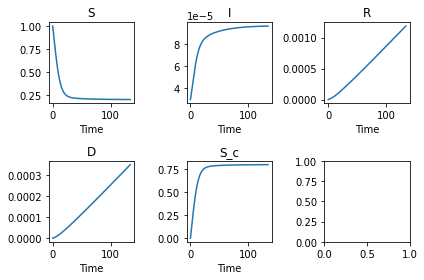

Peak infection (days) 134.0


In [40]:
# setup time points for simulation, initial conditions and parameters
t = np.linspace(0, lastday -1, lastday)

# initial conditions assuming there is no natural immunity
I_0 =  0.00003
x0_SCIR = [1.0-I_0, I_0, 0.0, 0.0, 0.0]

# Define parameters based on clinical observations Dr. Alison
Exposure=0.25 # Rate coefficient for exposure per individual in contact per day
IncubPeriod=5  #Incubation period, days
DurInf=10 #Duration of mild infections, days
FracCritical=0.1 #Fraction of infections that are critical
CFR=0.05 #Case fatality rate (fraction of infections resulting in death)
TimeDeath=DurInf+7 #Time from ICU admission to death, days

# Model extension by John McCaskill to include caution 
CautionFactor= 0.4 # Fractional reduction of exposure rate for cautioned individuals
CautionRetention= 21. # Duration of cautionary state of susceptibles (2 weeks)
CautionICUFrac= 0.25 # Fraction of ICUs occupied leading to transition to caution @ 1/day
ICUFrac= 0.002 # Fraction of ICUs relative to population size N

# Model fitting extension to allow for incomplete detection
FracConfirmedDet=0.125  # Fraction of recovered individuals measured
FracRecoveredDet=FracConfirmedDet # Fraction of recovered individuals measured
FracDeathsDet=1.0

# convert above parameters to model parameters
params = {'beta' : Exposure/sum(x0_SCIR),
          'gamma': (1.0/DurInf),
          'mu'    : (1.0/TimeDeath)*(CFR/FracCritical),
          'c_0'    : CautionFactor,
          'c_1'    : 1.0/CautionRetention,
          'c_2'    : 1.0/(sum(x0_SCIR)*ICUFrac*CautionICUFrac),
          'N'     : sum(x0_SCIR)}
print(params)
# assign x0 and params to the model, integrate over t and plot
SCIR_model.initial_values = (x0_SCIR, t[0])
SCIR_model.parameters = params
SCIR_model.params = params.copy()
solution = SCIR_model.integrate(t[1::])

SCIR_model.plot()

# calculate time point when maximum number of people are infectious
peak_i = np.argmax(solution[:,1])
print('Peak infection (days)', t[peak_i])

### Integration and plot using scipy and matplotlib directly

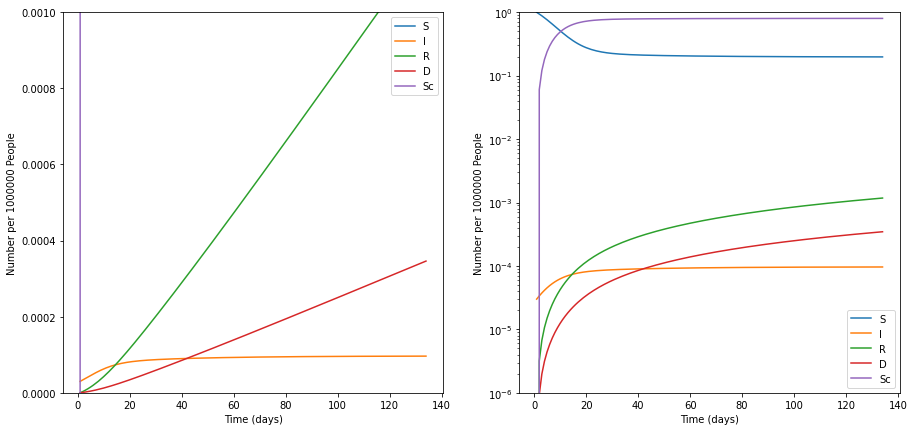

In [41]:
solution1 = scipy.integrate.odeint(SCIR_model.ode, x0_SCIR, t[1::])
ys = solution1.copy()
plt.figure(figsize=(15,7))
plt.subplot(1,2,1)
plt.xlabel("Time (days)")
plt.ylabel("Number per 1000000 People")
plt.ylim([0,0.001])
plt.plot(t[1::],ys,label=("S","I","R","D","Sc"))
plt.legend(("S","I","R","D","Sc"))
plt.subplot(1,2,2)
plt.xlabel("Time (days)")
plt.ylabel("Number per 1000000 People")
plt.ylim([0.000001,1])
plt.semilogy()
plt.plot(t[1::],ys,label=("S","I","R","D","Sc"))
plt.legend(("S","I","R","D","Sc"));

### Compare data with SCIR simulation

parameters {beta: 0.15, gamma: 0.1, mu: 0.029411764705882353, c_0: 0.85, c_1: 0.047619047619047616, c_2: 2000.0, N: 1.0}
initial conditions [0.99997, 3e-05, 0.0, 0.0, 0.0]
Peak infection (days) 133.0


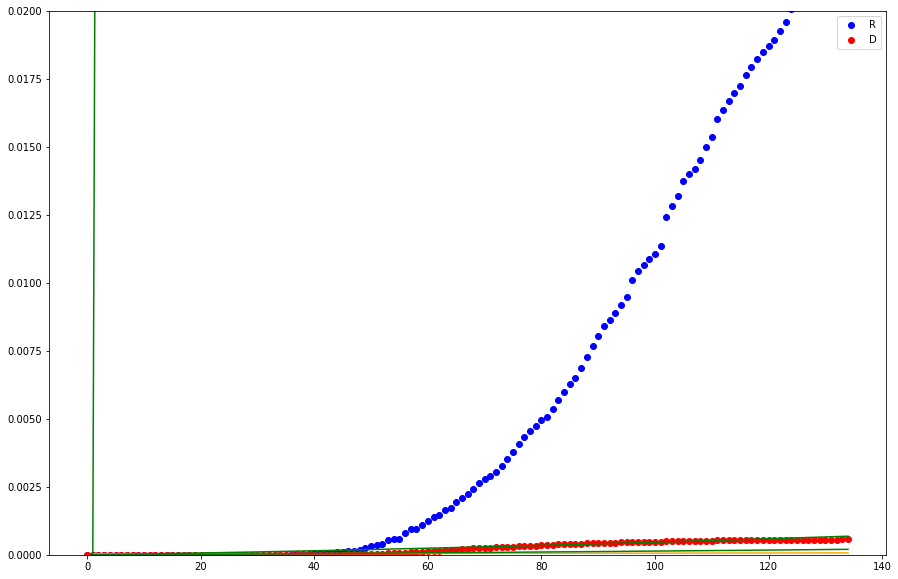

In [42]:
# model with generating parameters 
params1 = SCIR_model.params.copy()
params1['c_0']=0.85
params1['beta']=0.15
SCIR_model.parameters = params1
print('parameters',SCIR_model.parameters)
x0_fit = x0_SCIR.copy()
print('initial conditions',x0_fit)
t_fit = t
SCIR_model.initial_values = (x0_fit, t_fit[0])
sol_fit = scipy.integrate.odeint(SCIR_model.ode, x0_fit, t_fit[1::])
plt.figure(figsize=(15,10))
plt.plot(t,y_jhu[test_country][:,1]/FracRecoveredDet, 'bo',label='R') # recovered
plt.plot(t,y_jhu[test_country][:,2], 'ro',label='D') # died
plt.gca().set_prop_cycle(color=['grey','orange','green','green','green','blue','red', 'black'])
plt.plot(t_fit[1::], sol_fit)
plt.ylim([0,0.02])
plt.legend()
peak_i = np.argmax(sol_fit[:,2])
print('Peak infection (days)', t_fit[peak_i])

## Simulation of SC2IR model

parameters {'beta': 0.25, 'gamma': 0.1, 'mu': 0.029411764705882353, 'c_0': 0.4, 'c_1': 0.047619047619047616, 'c_2': 2000.0, 'N': 1.0}


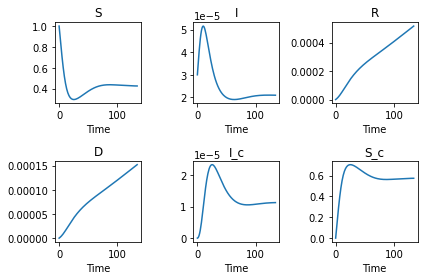

Peak infection (days) 10.0


In [43]:
# setup time points for simulation, initial conditions and parameters
t = np.linspace(0, lastday -1, lastday)

# initial conditions assuming there is no natural immunity
I_0 =  0.00003
x0 = [1.0-I_0, I_0, 0.0, 0.0, 0.0, 0.0]

# Define parameters based on clinical observations Dr. Alison
Exposure=0.25 # Rate coefficient for exposure per individual in contact per day
IncubPeriod=5  #Incubation period, days
DurInf=10 #Duration of mild infections, days
FracCritical=0.1 #Fraction of infections that are critical
CFR=0.05 #Case fatality rate (fraction of infections resulting in death)
TimeDeath=DurInf+7 #Time from ICU admission to death, days

# Model extension by John McCaskill to include caution 
CautionFactor= 0.4 # Fractional reduction of exposure rate for cautioned individuals
CautionRetention= 21. # Duration of cautionary state of susceptibles (2 weeks)
CautionICUFrac= 0.25 # Fraction of ICUs occupied leading to transition to caution @ 1/day
ICUFrac= 0.002 # Fraction of ICUs relative to population size N

# Model fitting extension to allow for incomplete detection
FracConfirmedDet=0.125  # Fraction of recovered individuals measured
FracRecoveredDet=FracConfirmedDet # Fraction of recovered individuals measured
FracDeathsDet=1.0

# convert above parameters to model parameters
params = {'beta' : Exposure/sum(x0),
          'gamma': (1.0/DurInf),
          'mu'    : (1.0/TimeDeath)*(CFR/FracCritical),
          'c_0'    : CautionFactor,
          'c_1'    : 1.0/CautionRetention,
          'c_2'    : 1.0/(sum(x0)*ICUFrac*CautionICUFrac),
          'N'     : sum(x0)}
print('parameters',params)
# assign x0 and params to the model, integrate over t and plot
SC2IR_model.initial_values = (x0, t[0])
SC2IR_model.parameters = params
SC2IR_model.params = params.copy()
solution = SC2IR_model.integrate(t[1::])

SC2IR_model.plot()

# calculate time point when maximum number of people are infectious
peak_i = np.argmax(solution[:,1])
print('Peak infection (days)', t[peak_i])

### Integration and plot using scipy and matplotlib directly

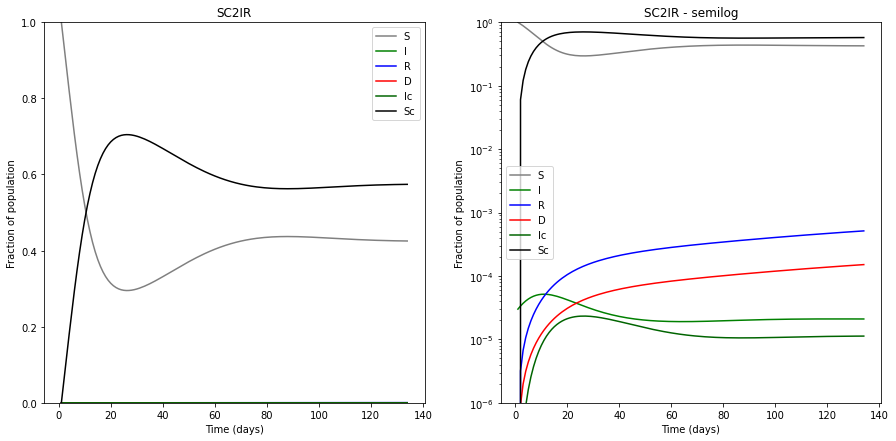

In [44]:
solution1 = scipy.integrate.odeint(SC2IR_model.ode, x0, t[1::])
ys = solution1.copy()
plt.figure(figsize=(15,7))
plt.subplot(1,2,1)
plt.xlabel("Time (days)")
plt.ylabel("Fraction of population")
plt.ylim([0,1])
plt.gca().set_prop_cycle(color=['grey','green','blue','red','darkgreen', 'black'])
plt.plot(t[1::],ys,label=("S","I","R","D",'Ic',"Sc"))
plt.legend(("S","I","R","D","Ic","Sc"))
plt.title(SC2IR_model.modelname)
plt.subplot(1,2,2)
plt.xlabel("Time (days)")
plt.ylabel("Fraction of population")
plt.ylim([0.000001,1])
plt.semilogy()
plt.gca().set_prop_cycle(color=['grey','green','blue','red','darkgreen', 'black'])
plt.plot(t[1::],ys,label=("S","I","R","D",'Ic',"Sc"))
plt.legend(("S","I","R","D","Ic","Sc"))
plt.title(SC2IR_model.modelname + ' - semilog');

### Compare data with SC2IR simulation

In [45]:
# model with generating parameters 
def isolveplot(beta,gamma,mu,c_0,c_1,c_2,logI_0):
    # saveparams=SC2IR_model.parameters.copy() # backup model current parameters
    # saveICs = SC2IR_model.initial_values # back model ICs
    I_0 = 10.**logI_0
    x0 = [1.0-I_0, I_0, 0.0, 0.0, 0.0, 0.0]
    params = {'beta' : beta,
          'gamma': gamma,
          'mu'    : mu,
          'c_0'    : c_0,
          'c_1'    : c_1,
          'c_2'    : c_2,
          'N'     : sum(x0)}
    SC2IR_model.initial_values = (x0, t[0])
    SC2IR_model.parameters = params.copy()
    
    sol_fit = scipy.integrate.odeint(SC2IR_model.ode, x0, t[1::])
    #
    plt.figure(figsize=(15,10))
    plt.plot(t,y_jhu[test_country][:,1]/FracRecoveredDet, 'bo',label='R') # recovered
    plt.semilogy()
    plt.plot(t,y_jhu[test_country][:,2], 'ro',label='D') # died
    plt.semilogy()
    plt.gca().set_prop_cycle(color=['grey','green','blue','red','darkgreen','black'])
    plt.plot(t[1::], sol_fit)
    plt.ylim([0.000001,1])
    plt.semilogy()
    plt.legend(('R','D','S','I','R','D','I_c','S_c'))
    #plt.show(())
    #ode_fit.plot()

    peak_i = np.argmax(sol_fit[:,2])
    print('Peak infection (days)', t_fit[peak_i])
    # SC2IR_model.parameters=saveparams.copy()
    # SC2IR_model.initial_values=saveICs

In [46]:
params = {'beta' : 0.25,
          'gamma': 0.1,
          'mu'    : 0.05,
          'c_0'    : 0.3,
          'c_1'    : 1./14.,
          'c_2'    : 2000.,
          'N'     : 1.}
interact(isolveplot,
         beta=FloatSlider(min=0,max=1,step=0.01,value=params['beta'],description='beta',
                            style=style,layout=slider_layout,continuous_update=False,readout_format='.3f'),
         gamma=FloatSlider(min=0,max=1,step=0.01,value=params['gamma'],description='gamma',
                            style=style,layout=slider_layout,continuous_update=False,readout_format='.3f'),
         mu=FloatSlider(min=0,max=0.1,step=0.001,value=params['mu'],description='mu',
                            style=style,layout=slider_layout,continuous_update=False,readout_format='.3f'),     
         c_0=FloatSlider(min=0,max=1,step=0.01,value=params['c_0'],description='c_0',
                            style=style,layout=slider_layout,continuous_update=False,readout_format='.3f'),
         c_1=FloatSlider(min=0,max=1,step=0.001,value=params['c_1'],description='c_1',
                            style=style,layout=slider_layout,continuous_update=False,readout_format='.3f'),
         c_2=FloatSlider(min=0,max=5000,step=1,value=params['c_2'],description='c_2',
                            style=style,layout=slider_layout,continuous_update=False,readout_format='.1f'),
         logI_0=FloatSlider(min=-10,max=0,step=0.01,value=np.log10(x0[1]),description='log I_0',
                            style=style,layout=slider_layout,continuous_update=False))

interactive(children=(FloatSlider(value=0.25, continuous_update=False, description='beta', layout=Layout(width…

<function __main__.isolveplot(beta, gamma, mu, c_0, c_1, c_2, logI_0)>

In [47]:
slide_params=SC2IR_model.parameters.copy()
print(slide_params)
theta = [0.4,0.11,0.007,0.33,0.228,275.]

{beta: 0.25, gamma: 0.1, mu: 0.05, c_0: 0.3, c_1: 0.07142857142857142, c_2: 2000.0, N: 1.0}


## Simulation of SCEI3R model

{'beta_1': 0.25, 'beta_2': 0.0, 'beta_3': 0.0, 'alpha': 0.2, 'gamma_1': 0.06999999999999999, 'gamma_2': 0.06060606060606061, 'gamma_3': 0.042857142857142844, 'p_1': 0.030000000000000013, 'p_2': 0.030303030303030304, 'mu': 0.1, 'c_0': 0.2, 'c_1': 0.047619047619047616, 'c_2': 1666.6666666666667, 'N': 1.0}


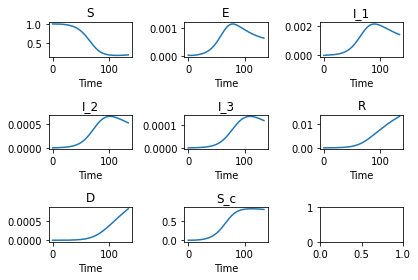

Peak infection (days) 89.0


In [48]:
# setup time points for simulation, initial conditions and parameters
t = np.linspace(0, lastday -1, lastday)

# initial conditions assuming there is no natural immunity
E_0 =  0.00003
x0_SCEI3R = [1.0-E_0, E_0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

# Define parameters based on clinical observations Dr. Alison
Exposure=0.25 # Rate coefficient for exposure per individual in contact per day
IncubPeriod=5  #Incubation period, days
DurMildInf=10 #Duration of mild infections, days
FracMild=0.70  #Fraction of infections that are mild
FracSevere=0.20 #Fraction of infections that are severe
FracCritical=0.1 #Fraction of infections that are critical
CFR=0.07 #Case fatality rate (fraction of infections resulting in death)
TimeICUDeath=7 #Time from ICU admission to death, days
DurHosp=11 #Duration of hospitalization, days

# Model extension by John McCaskill to include caution 
CautionFactor= 0.2 # Fractional reduction of exposure rate for cautioned individuals
CautionRetention= 21. # Duration of cautionary state of susceptibles (2 weeks)
CautionICUFrac= 0.3 # Fraction of ICUs occupied leading to transition to caution @ 1/day
ICUFrac= 0.002 # Fraction of ICUs relative to population size N

# Model fitting extension to allow for incomplete detection
FracConfirmedDet=0.125  # Fraction of recovered individuals measured
FracRecoveredDet=FracConfirmedDet # Fraction of recovered individuals measured
FracDeathsDet=1.0

# convert above parameters to model parameters
params = {'beta_1' : Exposure/sum(x0_SCEI3R),
          'beta_2' : 0.0,
          'beta_3' : 0.0,
          'alpha' : 1.0/IncubPeriod,
          'gamma_1': (1.0/DurMildInf)*FracMild,
          'gamma_2': (1.0/DurHosp)-(1/DurHosp)*(FracCritical/(FracCritical+FracSevere)),
          'gamma_3': (1.0/TimeICUDeath)-(1/TimeICUDeath)*(CFR/FracCritical),
          'p_1'    : (1.0/DurMildInf)-(1.0/DurMildInf)*FracMild,
          'p_2'    : (1.0/DurHosp)*(FracCritical/(FracCritical+FracSevere)),
          'mu'    : (1.0/TimeICUDeath)*(CFR/FracCritical),
          'c_0'    : CautionFactor,
          'c_1'    : 1.0/CautionRetention,
          'c_2'    : 1.0/(sum(x0_SCEI3R)*ICUFrac*CautionICUFrac),
          'N'     : sum(x0_SCEI3R)}
print(params)
# assign x0 and params to the model, integrate over t and plot
SCEI3R_model.initial_values = (x0_SCEI3R, t[0])
SCEI3R_model.parameters = params
SCEI3R_model.params = params.copy()
solution = SCEI3R_model.integrate(t[1::])

SCEI3R_model.plot()

# calculate time point when maximum number of people are infectious
peak_i = np.argmax(solution[:,2])
print('Peak infection (days)', t[peak_i])

### Compare data with SCEI3R simulation

{beta_1: 0.25, beta_2: 0.0, beta_3: 0.0, alpha: 0.2, gamma_1: 0.06999999999999999, gamma_2: 0.06060606060606061, gamma_3: 0.042857142857142844, p_1: 0.030000000000000013, p_2: 0.030303030303030304, mu: 0.1, c_0: 0.7, c_1: 0.047619047619047616, c_2: 1666.6666666666667, N: 1.0}
[0.99997, 3e-05, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
135
Peak infection (days) 133.0


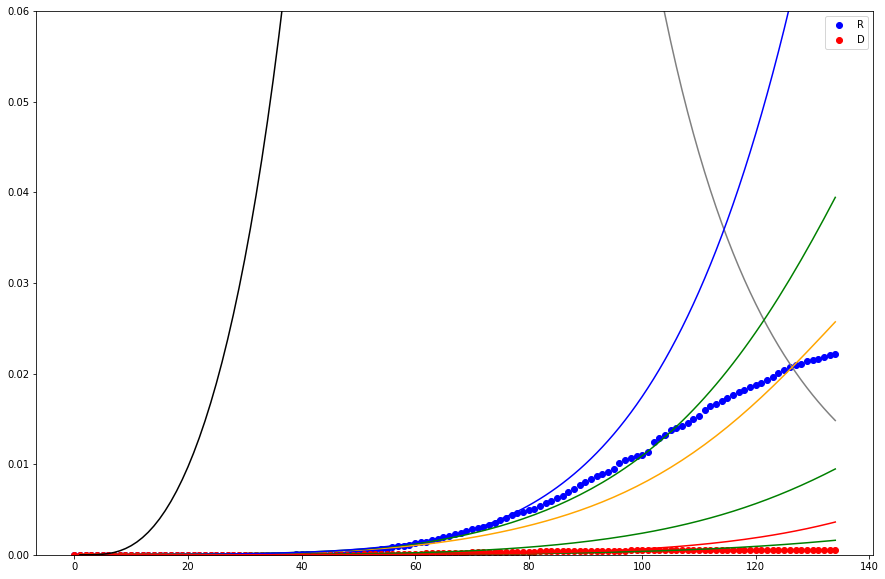

In [49]:
# model with generating parameters 
params1 = SCEI3R_model.params.copy()
params1['c_0']=0.7
SCEI3R_model.parameters = params1
print(SCEI3R_model.parameters)
x0_fit = x0_SCEI3R.copy()
# x0_fit[2] = 0.00001
#t_fit = numpy.linspace(0, 150, 1000)
print(x0_fit)
t_fit = t
print(len(t))
SCEI3R_model.initial_values = (x0_fit, t_fit[0])
# %timeit sol_fit =SCEI3R_model.integrate(t_fit[1::]) # use magic %timeit to time
#sol_fit =SCEI3R_model.integrate(t_fit[1::])
# sol_fit = SCEI3R_model.integrate(t_fit)
sol_fit = scipy.integrate.odeint(SCEI3R_model.ode, x0_fit, t_fit[1::])
# print(len(sol_fit[0]))
#
plt.figure(figsize=(15,10))
#plt.plot(t,y_jhu[test_country][:,0], 'go',label='I_1') # infected observations
#plt.plot(t,y_jhu[test_country][:,1], 'go',label='I_2') # infected observations
#plt.plot(t,y_jhu[test_country][:,2], 'go',label='I_3') # infected observations
plt.plot(t,y_jhu[test_country][:,1]/FracRecoveredDet, 'bo',label='R') # recovered
plt.plot(t,y_jhu[test_country][:,2], 'ro',label='D') # died
plt.gca().set_prop_cycle(color=['grey','orange','green','green','green','blue','red','black',])
plt.plot(t_fit[1::], sol_fit)
plt.ylim([0,0.06])
plt.legend()
#plt.show(())
#ode_fit.plot()

peak_i = np.argmax(sol_fit[:,2])
print('Peak infection (days)', t_fit[peak_i])

### Integration and plot using scipy and matplotlib directly

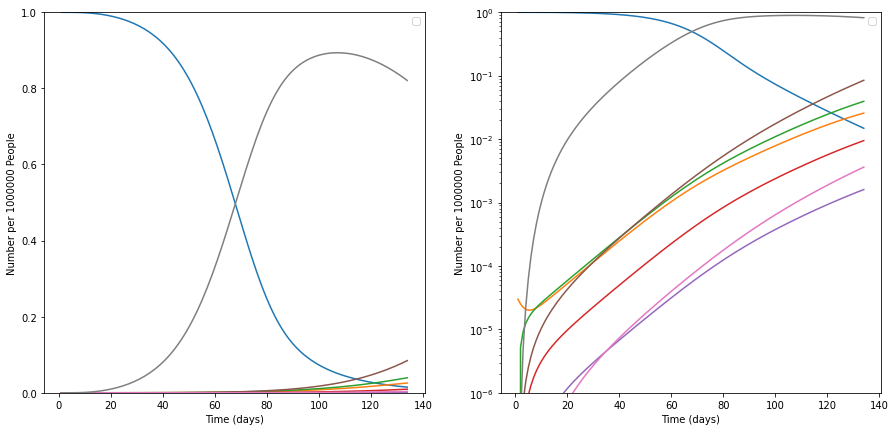

In [50]:
# solution = scipy.integrate.odeint(SCEI3R_model.ode, x0, t)
# print(len(t))
solution1 = scipy.integrate.odeint(SCEI3R_model.ode, x0_SCEI3R, t[1::])
ys = solution1.copy()
plt.figure(figsize=(15,7))
plt.subplot(1,2,1)
plt.xlabel("Time (days)")
plt.ylabel("Number per 1000000 People")
plt.ylim([0,1])
plt.legend(("S","E","I1","I2","I3","R","D","Sc"))
plt.plot(t[1::],ys)
plt.subplot(1,2,2)
plt.xlabel("Time (days)")
plt.ylabel("Number per 1000000 People")
plt.ylim([0.000001,1])
plt.legend(("S","E","I1","I2","I3","R","D","Sc"))
plt.semilogy()
plt.plot(t[1::],ys);

## Simulation of SC3EI3R model

{'beta_1': 0.25, 'beta_2': 0.0, 'beta_3': 0.0, 'alpha': 0.2, 'gamma_1': 0.06999999999999999, 'gamma_2': 0.06060606060606061, 'gamma_3': 0.042857142857142844, 'p_1': 0.030000000000000013, 'p_2': 0.030303030303030304, 'mu': 0.1, 'c_0': 0.2, 'c_1': 0.047619047619047616, 'c_2': 1666.6666666666667, 'N': 1.0}


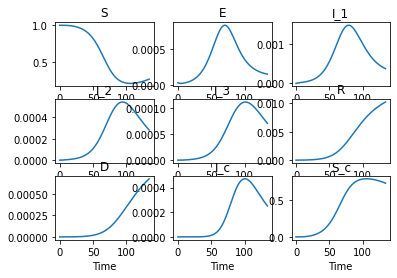

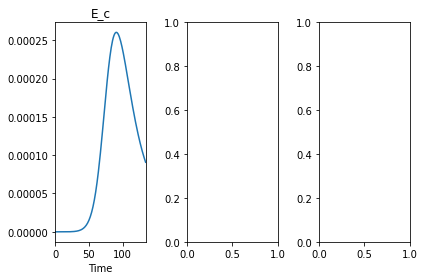

Peak infection (days) 79.0


In [51]:
# setup time points for simulation, initial conditions and parameters
t = np.linspace(0, lastday -1, lastday)
tmax=lastday-1
# initial conditions assuming there is no natural immunity
E_0 =  0.00003
x0_SC3EI3R = [1.0-E_0, E_0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

# Define parameters based on clinical observations Dr. Alison
Exposure=0.25 # Rate coefficient for exposure per individual in contact per day
IncubPeriod=5  #Incubation period, days
DurMildInf=10 #Duration of mild infections, days
FracMild=0.70  #Fraction of infections that are mild
FracSevere=0.20 #Fraction of infections that are severe
FracCritical=0.1 #Fraction of infections that are critical
CFR=0.07 #Case fatality rate (fraction of infections resulting in death)
TimeICUDeath=7 #Time from ICU admission to death, days
DurHosp=11 #Duration of hospitalization, days

# Model fitting extension to allow for incomplete detection
FracConfirmedDet=0.125  # Fraction of recovered individuals measured
FracRecoveredDet=FracConfirmedDet # Fraction of recovered individuals measured
FracDeathsDet=1.0

# Model extension by John McCaskill to include caution 
CautionFactor= 0.2 # Fractional reduction of exposure rate for cautioned individuals
CautionRetention= 21. # Duration of cautionary state of susceptibles (2 weeks)
CautionICUFrac= 0.3 # Fraction of ICUs occupied leading to transition to caution @ 1/day
ICUFrac= 0.002 # Fraction of ICUs relative to population size N


# convert above parameters to model parameters
params = {'beta_1' : Exposure/sum(x0_SC3EI3R),
          'beta_2' : 0.0,
          'beta_3' : 0.0,
          'alpha' : 1.0/IncubPeriod,
          'gamma_1': (1.0/DurMildInf)*FracMild,
          'gamma_2': (1.0/DurHosp)-(1/DurHosp)*(FracCritical/(FracCritical+FracSevere)),
          'gamma_3': (1.0/TimeICUDeath)-(1/TimeICUDeath)*(CFR/FracCritical),
          'p_1'    : (1.0/DurMildInf)-(1.0/DurMildInf)*FracMild,
          'p_2'    : (1.0/DurHosp)*(FracCritical/(FracCritical+FracSevere)),
          'mu'    : (1.0/TimeICUDeath)*(CFR/FracCritical),
          'c_0'    : CautionFactor,
          'c_1'    : 1.0/CautionRetention,
          'c_2'    : 1.0/(sum(x0_SC3EI3R)*ICUFrac*CautionICUFrac),
          'N'     : sum(x0_SC3EI3R)}

print(params)
# assign x0 and params to the model, integrate over t and plot
SC3EI3R_model.initial_values = (x0_SC3EI3R, t[0])
SC3EI3R_model.parameters = params
SC3EI3R_model.params = params.copy()
solution = SC3EI3R_model.integrate(t[1::])

SC3EI3R_model.plot()

# calculate time point when maximum number of people are infectious
peak_i = np.argmax(solution[:,2])
print('Peak infection (days)', t[peak_i])

### Compare data with SC3EI3R simulation

{beta_1: 0.25, beta_2: 0.0, beta_3: 0.0, alpha: 0.2, gamma_1: 0.06999999999999999, gamma_2: 0.06060606060606061, gamma_3: 0.042857142857142844, p_1: 0.030000000000000013, p_2: 0.030303030303030304, mu: 0.1, c_0: 0.35, c_1: 0.047619047619047616, c_2: 1666.6666666666667, N: 1.0}
[0.99997, 3e-05, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
135
Peak infection (days) 79.0


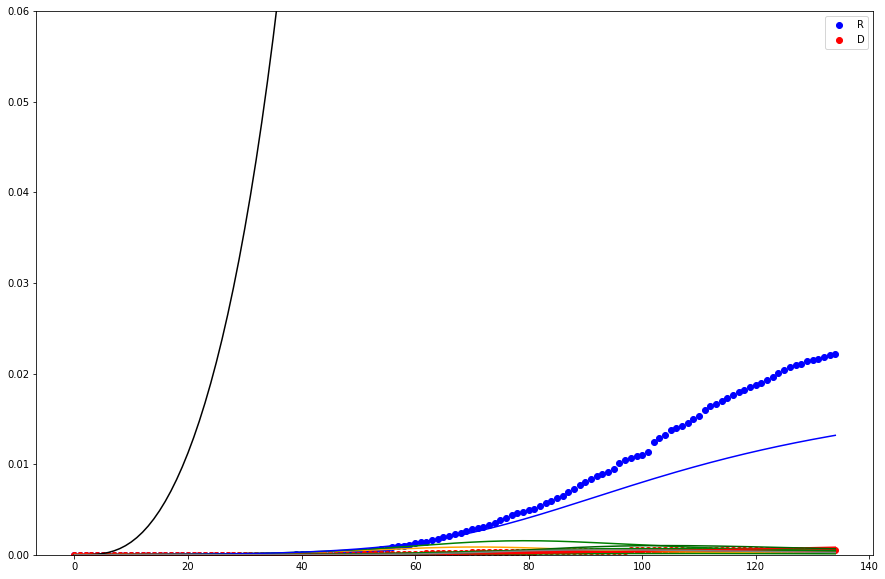

In [52]:
# model with generating parameters 
params1 = SC3EI3R_model.params.copy()
params1['c_0']=0.35
SC3EI3R_model.parameters = params1
print(SC3EI3R_model.parameters)
x0_fit = x0_SC3EI3R.copy()
# x0_fit[2] = 0.00001
#t_fit = numpy.linspace(0, 150, 1000)
print(x0_fit)
t_fit = t
print(len(t))
SC3EI3R_model.initial_values = (x0_fit, t_fit[0])
# %timeit sol_fit =SC3EI3R_model.integrate(t_fit[1::]) # use magic %timeit to time
sol_fit =SC3EI3R_model.integrate(t_fit[1::])
# sol_fit = SC3EI3R_model.integrate(t_fit)
# sol_fit = scipy.integrate.odeint(SC3EI3R_model(params_fit).ode, x0_fit, t_fit[1::])
# print(len(sol_fit[0]))
#
plt.figure(figsize=(15,10))
plt.plot(t,y_jhu[test_country][:,1]/FracRecoveredDet, 'bo',label='R') # recovered
plt.plot(t,y_jhu[test_country][:,2]/FracDeathsDet, 'ro',label='D') # died
plt.gca().set_prop_cycle(color=['grey','orange','green','green','green','blue','red','darkgreen', 'black'])
#plt.plot(t_fit[1::], sol_fit)
plt.plot(t_fit, sol_fit)
plt.ylim([0,0.06])
plt.legend()
#plt.show(())
#ode_fit.plot()

peak_i = np.argmax(sol_fit[:,2])
print('Peak infection (days)', t_fit[peak_i])

## Simulation models for range of caution parameters

### SCIR, SC2IR, SCEIR, SC3EIR,  SCEI3R and SC3EI3R simulations

In [121]:
SCIR_model.parameters

{beta: 0.25,
 gamma: 0.098,
 mu: 0.001999999999999999,
 c_0: 0.2,
 c_1: 0.047619047619047616,
 c_2: 1666.6666666666667,
 N: 1}

In [122]:
def param_copy(model):
    params = model.parameters
    newparams = {}
    pkeys1 = list(model.params.keys())
    pkeys2 = list(model.parameters.keys())
    for i in range(len(pkeys1)):
        newparams[pkeys1[i]] = params[pkeys2[i]]
    print(newparams)
    model.parameters=newparams
    
def param_modify(model,param,value):
    params = model.parameters
    newparams = {}
    pkeys1 = list(model.params.keys())
    pkeys2 = list(model.parameters.keys())
    for i in range(len(pkeys1)):
        newparams[pkeys1[i]] = params[pkeys2[i]]
    newparams[param]=value
    print(newparams)
    model.parameters=newparams
    
param_modify(SCIR_model,'beta',0.721)

{'beta': 0.721, 'gamma': 0.098, 'mu': 0.001999999999999999, 'c_0': 0.2, 'c_1': 0.047619047619047616, 'c_2': 1666.6666666666667, 'N': 1}


In [123]:
SCIR_model.parameters = {'gamma':0.4}
SCIR_model.parameters

{beta: 0.721,
 gamma: 0.4,
 mu: 0.001999999999999999,
 c_0: 0.2,
 c_1: 0.047619047619047616,
 c_2: 1666.6666666666667,
 N: 1}

In [124]:
def vector2params(b,a,g,p,u,c,N,modelname):
    if 'I3' in modelname:
        params = {
            'beta_1' : b[1],
            'beta_2' : b[2],
            'beta_3' : b[3],
            'alpha' : a,
            'gamma_1': g[1],
            'gamma_2': g[2],
            'gamma_3': g[3],
            'p_1'    : p[1],
            'p_2'    : p[2],
            'mu'    : u}
    elif 'E' in modelname:
        params = {
            'beta' : b[1],  # see above for explanations
            'alpha' : a, 
            'gamma': g[1]+g[2]*(p[1]/(g[2]+p[2]))+g[3]*(p[1]/(g[2]+p[2]))*(p[2]/(g[3]+u)),
            'mu'    : u*(p[1]/(g[2]+p[2])*(p[2]/(g[3]+u)))}    
    else:
        params = {
            'beta' : b[1],  # see above for explanations
            'gamma': g[1]+g[2]*(p[1]/(g[2]+p[2]))+g[3]*(p[1]/(g[2]+p[2]))*(p[2]/(g[3]+u)),
            'mu'    : u*(p[1]/(g[2]+p[2])*(p[2]/(g[3]+u)))}
            
    if 'C' in modelname: # models with caution  
        params['c_0'] = c[0]
        params['c_1'] = c[1]
        params['c_2'] = c[2]
    params['N'] = N
    return params

def params2vector(params):
    b = [None,None,None]
    g = [None,None,None]
    p = [None,None,None]
    c = [None,None,None]
    b[0]=0.0
    b[1]=params['beta_1']
    b[2]=params['beta_2']
    b[3]=params['beta_3']
    g[0]=0.0
    g[1]=params['gamma_1']
    g[2]=params['gamma_2']
    g[3]=params['gamma_3']
    p[0]=0.0
    p[1]=params['p_1']
    p[2]=params['p_2']
    c[0]=params['c_1']
    c[1]=params['c_2']
    c[2]=params['c_3']
    a=params['alpha']
    u=params['mu']
    N=params['N']
    return (b,a,g,p,u,c,N)

In [188]:
count = 0

def difference(datain):
    dataout = np.zeros(np.shape(datain))
    for i in range(1,len(datain)):
        dataout[i,...] = datain[i,...]-datain[i-1,...]
    return dataout
        
def rolling_average(datain,period):
    (tmax,n) = np.shape(datain)
    dataout = np.zeros((tmax,n),dtype=float)
    moving_av = np.zeros(n,dtype=float)
    for k in range(len(datain)):
        if k-period >= 0:
            moving_av[:] = moving_av[:] - datain[k-7,...]
        moving_av[:] = moving_av[:] + datain[k,...]
        dataout[k] = moving_av/min(float(period),float(k+1))
    return dataout
        
def solveplot(smodels=['SIR','SCIR','SC2IR','SEIR','SCEIR','SC3EIR','SEI3R','SCEI3R','SC3EI3R'],species='EI',tmax=100,summing='daily',averaging='weekly',fitdata = None,scale='linear',plottitle= '',label='',
              newplot = True, gbrcolors=False):
    """
    solve ODEs and plot for set of models indicated
    params: dictionary of simulation parameters
    scale: alternative 'linear' or 'log'
    species alternatives 'all', 'EI', 'confirmed', 'deaths', 'daily confirmed', 'daily deaths'
    plottitle : title for plot
    label : label for curve when called as part of multicurve plot
    newplot : whether to open new plot True/False
    models : list of models to include, default all three of those possible
    """
    global count
    tvec=np.arange(0,tmax,1)
    tvec1 = tvec[1:]

    if not fitdata is None:
        tmaxf = len(fitdata)
        if fitdata.ndim != 2:
            print("error in number of dimensions of array")
        tvecf=np.arange(0,tmaxf,1)
        tvecf1 = tvecf[1:]
            
    nmodels = len(smodels)
    nm = 0
    
    count = count+1
    
    if newplot == True:
        plt.figure(figsize=(nmodels*8,6))
        # fig, axeslist = plt.subplots(1, nmodels, figsize=(nmodels*8,6))
        
    solns = []    
    for smodel in smodels:
        model = cmodels[smodel]
        nm = nm + 1
        soln = scipy.integrate.odeint(model.ode, model.initial_values[0], tvec[1::])
        #Plot
        # ax = axeslist[nm]
        plt.subplot(1,nmodels,nm)
        if scale == 'log': #Plot on log scale
            plt.semilogy()
            plt.ylim([0.00000001,1.0])
        if not isinstance(species,list):
            lspecies = [species]
        else:
            lspecies = species
            
        if summing == 'daily':
            ssoln = difference(soln)
            if not fitdata is None:
                sfit = difference(fitdata)
        else:
            ssoln = soln
            if not fitdata is None:
                sfit = fitdata
                
        if averaging == 'weekly':
            srsoln = rolling_average(ssoln,7)
            if not fitdata is None:
                srfit = rolling_average(sfit,7)
        else:
            srsoln = ssoln
            if not fitdata is None:
                srfit = sfit
                
        for species in lspecies:
            if species == 'confirmed':
                suma = np.sum(srsoln[:,model.confirmed],axis=1)
                if not fitdata is None:
                    plt.plot(tvec1,suma,label=label,color='green')
                    fita = srfit[1::,0] # confirmed cases data
                    plt.plot(tvecf1,fita,'o',label=label,color='green')
                else:
                    plt.plot(tvec1,suma,label=label)
            if species == 'recovered':
                suma = np.sum(srsoln[:,model.recovered],axis=1)   
                if not fitdata is None:
                    plt.plot(tvec1,suma,label=label,color='blue')
                    fita = srfit[1::,1] # recovered cases data
                    plt.plot(tvecf1,fita,'o',label=label,color='blue')
                else:
                    plt.plot(tvec1,suma,label=label)
            elif species == 'deaths':
                suma = np.sum(srsoln[:,model.deaths],axis=1)
                if not fitdata is None:
                    plt.plot(tvec1,suma,label=label,color='red')
                    fita = srfit[1::,2] # deaths cases data
                    plt.plot(tvecf1,fita,'o',label=label,color='red')
                else:
                    plt.plot(tvec1,suma,label=label)
            elif species == 'deaths_x10':
                suma = np.sum(srsoln[:,model.deaths],axis=1)*10
                if not fitdata is None:
                    plt.plot(tvec1,suma,label=label,color='red')
                    fita = srfit[1::,2]*10 # deaths cases data
                    plt.plot(tvecf1,fita,'o',label=label,color='red')
                else:
                    plt.plot(tvec1,suma,label=label)
            elif species == 'EI':
                plt.plot(tvec1,soln[:,model.ei],label=label)
                # plt.plot(tvec1,soln[:,model.ei],label="%s" % count)
                if 'I3' in model.modelname: 
                    plt.legend(("E","I1","I2","I3"))
                elif 'E' in model.modelname: 
                    plt.legend(("E","I"))
                else:
                    plt.legend(("I"))
            elif species == 'all':
                plt.plot(tvec1,soln,label=label)

                if 'I3' in model.modelname:
                    if 'C3'in model.modelname:
                        pspecies=("S","E","I1","I2","I3","R","D","Ic","Sc","Ec")
                    elif 'C' in model.modelname:
                        pspecies=("S","E","I1","I2","I3","R","D","Sc")
                    else:
                        pspecies=("S","E","I1","I2","I3","R","D")
                elif 'E' in model.modelname:
                    if 'C3'in model.modelname:
                        pspecies=("S","E","I","R","D","Ic","Sc","Ec")
                    else:
                        pspecies=("S","E","I","R","D","Sc")                
                else:
                    if 'C2'in model.modelname:
                        pspecies=("S","I","R","D","Ic","Sc")
                    else:
                        pspecies=("S","I","R","D","Sc")
                plt.legend(pspecies)
            
        plt.xlabel("Time (days)")
        plt.ylabel("Fraction of population")
        plt.title(model.modelname +' '+plottitle)
        solns.append(soln)
    return solns

In [126]:
# Set up multimodel consistent sets of parameters
Exposure=0.25 # Rate coefficient for exposure per individual in contact per day
IncubPeriod=5  #Incubation period, days 
DurMildInf=10 #Duration of mild infections, days
FracMild=0.8  #Fraction of infections that are mild
FracSevere=0.15 #Fraction of infections that are severe
FracCritical=0.05 #Fraction of infections that are critical
CFR=0.02 #Case fatality rate (fraction of infections resulting in death)
TimeICUDeath=7 #Time from ICU admission to death, days
DurHosp=11 #Duration of hospitalization, days

# Model extension by John McCaskill to include caution 
CautionFactor= 0.3 # Fractional reduction of exposure rate for cautioned individuals
CautionRetention= 14. # Duration of cautionary state of susceptibles (4 weeks)
CautionICUFrac= 0.25 # Fraction of ICUs occupied leading to 90% of susceptibles in caution 
ICUFrac= 0.001 # Fraction of ICUs relative to population size N

N=1
b=np.zeros(4) #beta
g=np.zeros(4) #gamma
p=np.zeros(3) # progression
c=np.zeros(3) #caution

a=1/IncubPeriod                    # transition rate from exposed to infected
b=Exposure*np.array([0,1,0,0])/N   # hospitalized cases don't transmit
u=(1/TimeICUDeath)*(CFR/FracCritical) # death rate from ICU
g[3]=(1/TimeICUDeath)-u            # recovery rate

p[2]=(1/DurHosp)*(FracCritical/(FracCritical+FracSevere))
g[2]=(1/DurHosp)-p[2]

g[1]=(1/DurMildInf)*FracMild
p[1]=(1/DurMildInf)-g[1]

c[0]=CautionFactor
c[1]=1/CautionRetention
c[2]=1/(N*ICUFrac*CautionICUFrac)   # this is the rate coefficient giving 1/day at IE = denom

cmodels = {'SIR':SIR_model,'SCIR':SCIR_model,'SC2IR':SC2IR_model,
           'SEIR':SEIR_model,'SCEIR':SCEIR_model,'SC3EIR':SC3EIR_model,
           'SEI3R':SEI3R_model,'SCEI3R':SCEI3R_model,'SC3EI3R':SC3EI3R_model}
smodels = ['SIR','SCIR','SC2IR','SEIR','SCEIR','SC3EIR','SEI3R','SCEI3R','SC3EI3R']

for smodel in smodels: 
    params_in=vector2params(b,a,g,p,u,c,N,smodel)
    # print(smodel,params_in)
    cmodels[smodel].parameters = params_in
    
I_0 =  0.00003

x0_SIR = [1.0-I_0, I_0, 0.0, 0.0]
x0_SCIR = [1.0-I_0, I_0, 0.0, 0.0, 0.0]
x0_SC2IR = [1.0-I_0, I_0, 0.0, 0.0, 0.0, 0.0]
SIR_model.initial_values = (x0_SIR, t[0])
SCIR_model.initial_values = (x0_SCIR, t[0])
SC2IR_model.initial_values = (x0_SC2IR, t[0])

x0_SEIR = [1.0-I_0, 0.0, I_0, 0.0, 0.0]
x0_SCEIR = [1.0-I_0, 0.0, I_0, 0.0, 0.0, 0.0]
x0_SC3EIR = [1.0-I_0, 0.0, I_0, 0.0, 0.0, 0.0, 0.0, 0.0]
SEIR_model.initial_values = (x0_SEIR, t[0])
SCEIR_model.initial_values = (x0_SCEIR, t[0])
SC3EIR_model.initial_values = (x0_SC3EIR, t[0])

x0_SEI3R = [1.0-I_0, 0.0, I_0, 0.0, 0.0, 0.0, 0.0]
x0_SCEI3R = [1.0-I_0, 0.0, I_0, 0.0, 0.0, 0.0, 0.0, 0.0]
x0_SC3EI3R = [1.0-I_0, 0.0, I_0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
SEI3R_model.initial_values = (x0_SEI3R, t[0])
SCEI3R_model.initial_values = (x0_SCEI3R, t[0])
SC3EI3R_model.initial_values = (x0_SC3EI3R, t[0])

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:59: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:59: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:59: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version,

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:59: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:59: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:59: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version,

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:59: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:59: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:59: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version,

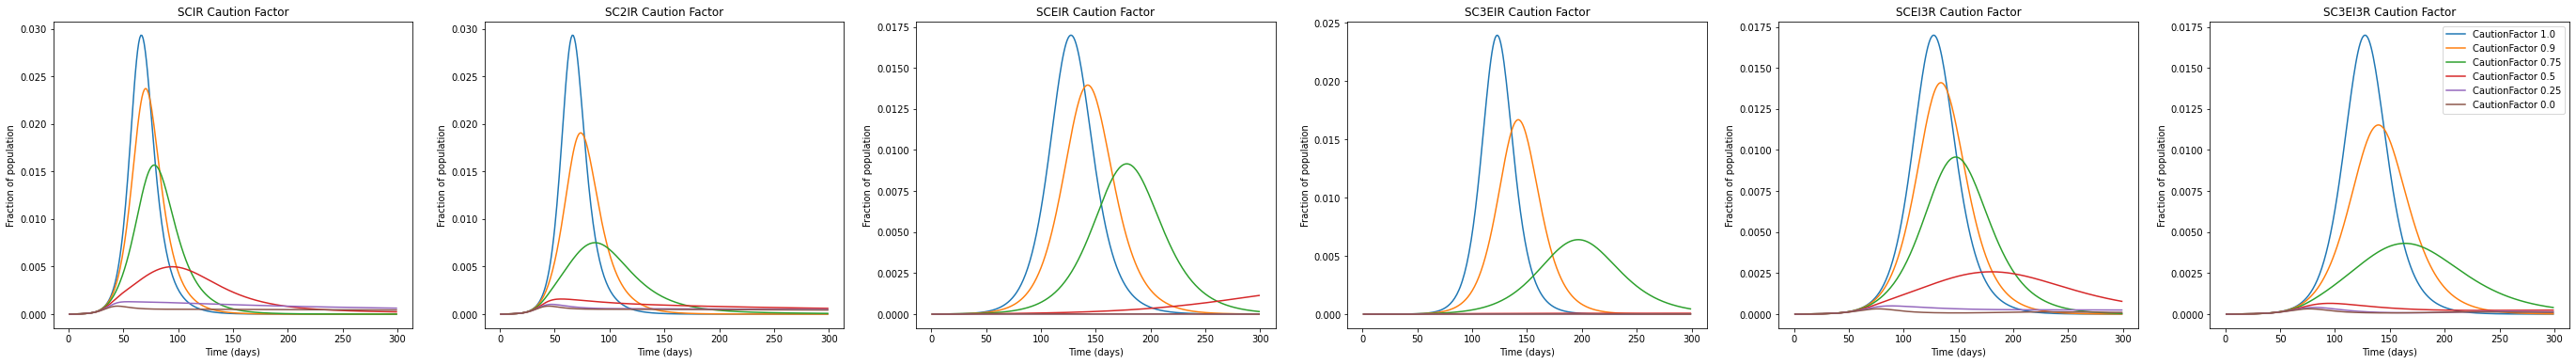

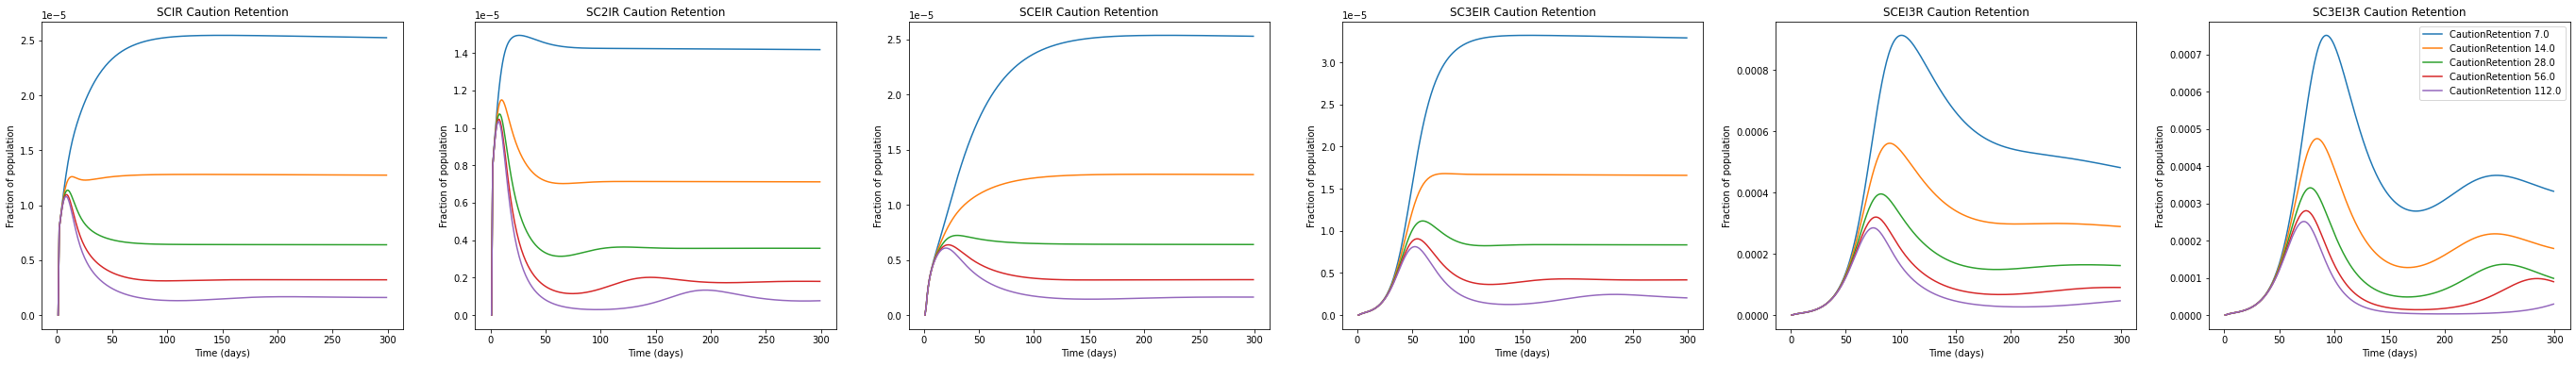

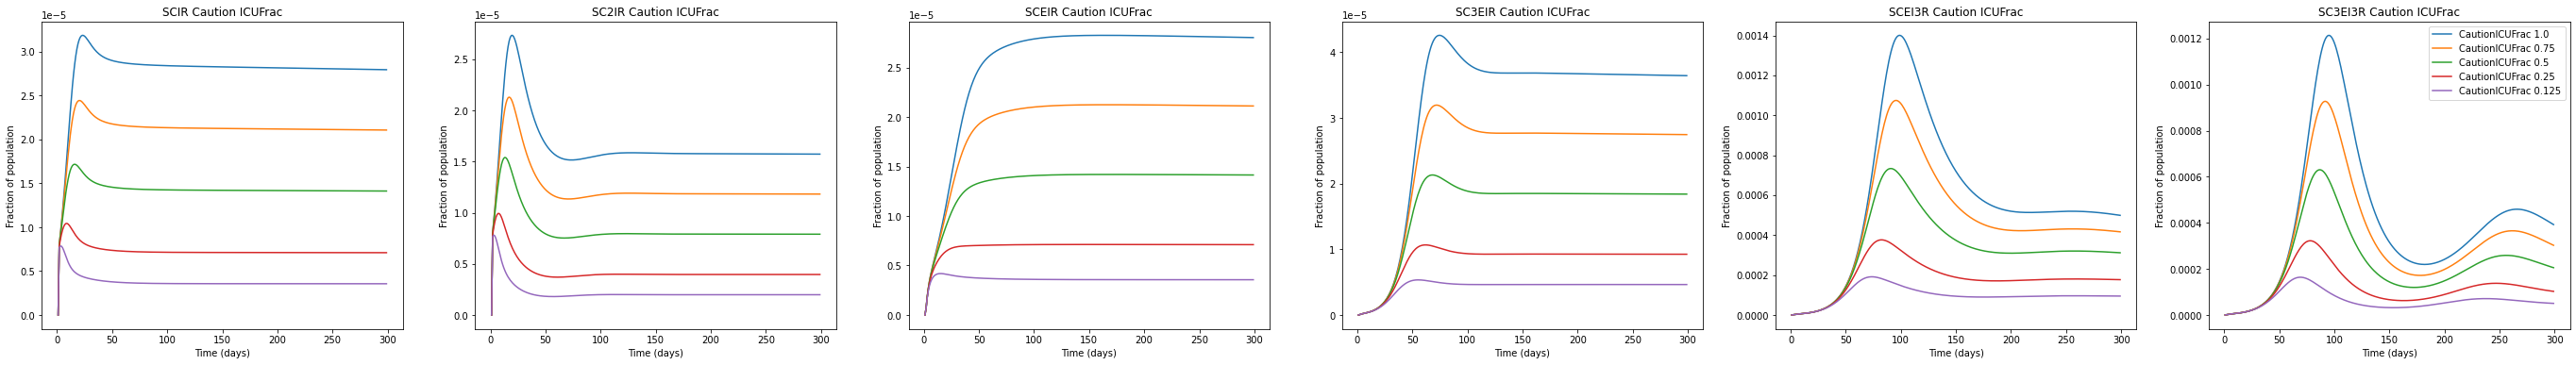

In [138]:
smodels = ['SCIR','SC2IR','SCEIR','SC3EIR','SCEI3R','SC3EI3R']
# tmax = lastday-1
tmax = 300
# caution standard parameters
CautionFactor= 0.2    # Fractional reduction of exposure rate for cautioned individuals
CautionRetention= 21. # Duration of cautionary state of susceptibles (4 weeks)
CautionICUFrac= 0.3   # Fraction of ICUs occupied leading to transition to caution @ 1/day 
ICUFrac= 0.002        # Fraction of ICUs relative to population size N

# Sensitivity scans
CautionFactors= [1.0,0.9,0.75,0.5,0.25,0.0]   # Fractional reduction of exposure rate for cautioned individuals
CautionRetentions= [7.,14.,28.,56.,112.,224.]      # Duration of cautionary state of susceptibles
CautionICUFracs= [1.0,0.75,0.5,0.25,0.125,0.0625] # Fraction of ICUs occupied leading to 90% of susceptibles in caution 

newplot = True
for s in range(6):
    for smodel in smodels:
        model = cmodels[smodel]
        if 'C' in model.modelname:
            if 'E' in model.modelname:
                cmodels[smodel].parameters = {'c_0':CautionFactors[s],'c_1':1./CautionRetention,'c_2':1./(N*ICUFrac*CautionICUFrac)}
            else:
                cmodels[smodel].parameters = {'c_0':CautionFactors[s],'c_1':1./CautionRetention,'c_2':FracSevere*FracCritical/(N*ICUFrac*CautionICUFrac)}
            # print(smodel,cmodels[smodel].parameters) 
        else:
            print("ERROR")
    label_c = 'CautionFactor %s' % CautionFactors[s]
    plottitle = 'Caution Factor' 
    solns=solveplot(smodels,'confirmed',tmax,'daily','daily',None,'linear',plottitle,label_c,newplot)
    plt.legend()
    newplot = False

newplot = True
#for i in reversed(range(5)):
for s in range(5):
    for smodel in smodels:
        model = cmodels[smodel]
        if 'C' in model.modelname:
            if 'E' in model.modelname:
                cmodels[smodel].parameters = {'c_0':CautionFactor,'c_1':1./CautionRetentions[s],'c_2':1./(N*ICUFrac*CautionICUFrac)}
            else:
                cmodels[smodel].parameters = {'c_0':CautionFactor,'c_1':1./CautionRetentions[s],'c_2':FracSevere*FracCritical/(N*ICUFrac*CautionICUFrac)}
            cmodels[smodel].parameters = {'c_0':CautionFactor,'c_1':1/CautionRetentions[s],'c_2':1./(N*ICUFrac*CautionICUFrac)}
            # print(smodel,cmodels[smodel].parameters) 
    label_c = 'CautionRetention %s'% CautionRetentions[s]
    plottitle = 'Caution Retention' 
    solns=solveplot(smodels,'confirmed',tmax,'daily','daily',None,'linear',plottitle,label_c,newplot)
    plt.legend()
    newplot = False

newplot = True    
for s in range(5):
    for smodel in smodels:
        model = cmodels[smodel]
        if 'C' in model.modelname:
            cmodels[smodel].parameters = {'c_0':CautionFactor,'c_1':1/CautionRetention,'c_2':1./(N*ICUFrac*CautionICUFracs[s])}
            # print(smodel,cmodels[smodel].parameters) 
    label_c = 'CautionICUFrac %s'% CautionICUFracs[s]
    plottitle = 'Caution ICUFrac' 
    solns=solveplot(smodels,'confirmed',tmax,'daily','daily',None,'linear',plottitle,label_c,newplot)
    plt.legend()
    newplot = False
    
# return parameters to standard set
for smodel in smodels:
    model = cmodels[smodel]
    if 'C' in model.modelname:
        cmodels[smodel].parameters = {'c_0':CautionFactor,'c_1':1/CautionRetention,'c_2':1./(N*ICUFrac*CautionICUFrac)}

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:59: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:59: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:59: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version,

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:59: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:59: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:59: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version,

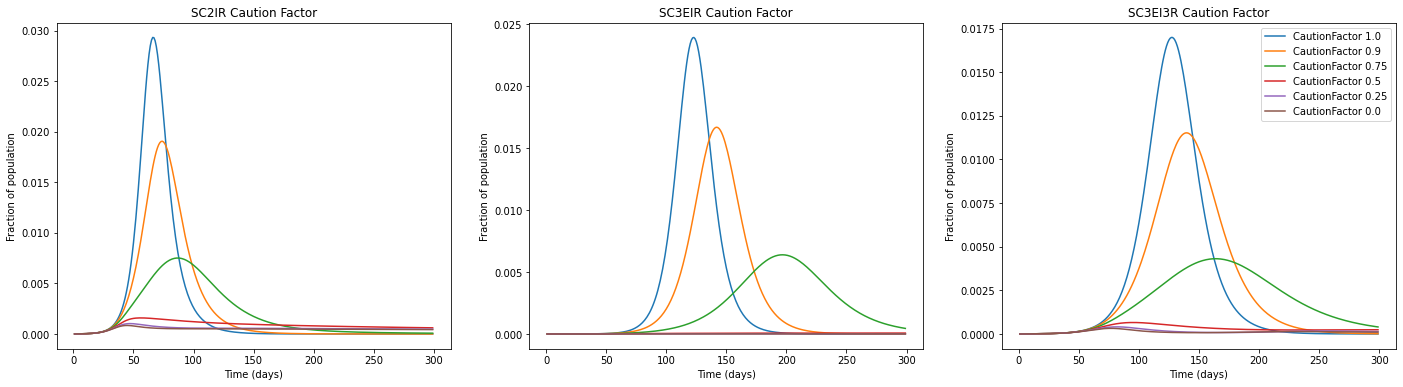

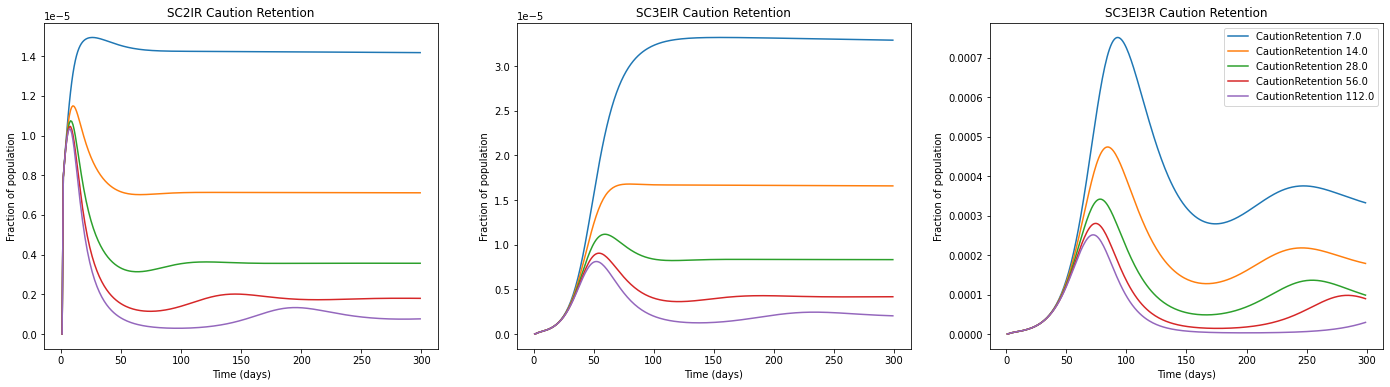

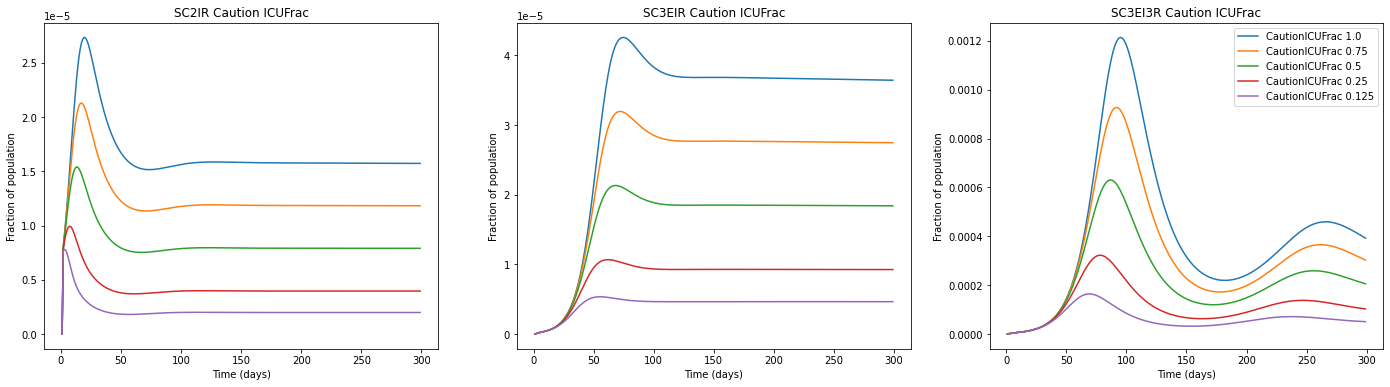

In [137]:
smodels = ['SC2IR','SC3EIR','SC3EI3R']
# tmax = lastday-1
tmax = 300
# caution standard parameters
CautionFactor= 0.2    # Fractional reduction of exposure rate for cautioned individuals
CautionRetention= 21. # Duration of cautionary state of susceptibles (4 weeks)
CautionICUFrac= 0.3   # Fraction of ICUs occupied leading to transition to caution @ 1/day 
ICUFrac= 0.002        # Fraction of ICUs relative to population size N

# Sensitivity scans
CautionFactors= [1.0,0.9,0.75,0.5,0.25,0.0]       # Fractional reduction of exposure rate for cautioned individuals
CautionRetentions= [7.,14.,28.,56.,112.,224.]   # Duration of cautionary state of susceptibles
CautionICUFracs= [1.0,0.75,0.5,0.25,0.125,0.0625] # Fraction of ICUs occupied leading to 90% of susceptibles in caution 
newplot = True
for s in range(6):
    for smodel in smodels:
        model = cmodels[smodel]
        if 'C' in model.modelname:
            if 'E' in model.modelname:
                cmodels[smodel].parameters = {'c_0':CautionFactors[s],'c_1':1./CautionRetention,'c_2':1./(N*ICUFrac*CautionICUFrac)}
            else:
                cmodels[smodel].parameters = {'c_0':CautionFactors[s],'c_1':1./CautionRetention,'c_2':FracSevere*FracCritical/(N*ICUFrac*CautionICUFrac)}
            # print(smodel,cmodels[smodel].parameters) 
        else:
            print("ERROR")
    label_c = 'CautionFactor %s' % CautionFactors[s]
    plottitle = 'Caution Factor' 
    solns=solveplot(smodels,'confirmed',tmax,'daily','daily',None,'linear',plottitle,label_c,newplot)
    plt.legend()
    newplot = False

newplot = True
#for i in reversed(range(5)):
for s in range(5):
    for smodel in smodels:
        model = cmodels[smodel]
        if 'C' in model.modelname:
            if 'E' in model.modelname:
                cmodels[smodel].parameters = {'c_0':CautionFactor,'c_1':1./CautionRetentions[s],'c_2':1./(N*ICUFrac*CautionICUFrac)}
            else:
                cmodels[smodel].parameters = {'c_0':CautionFactor,'c_1':1./CautionRetentions[s],'c_2':FracSevere*FracCritical/(N*ICUFrac*CautionICUFrac)}
            cmodels[smodel].parameters = {'c_0':CautionFactor,'c_1':1/CautionRetentions[s],'c_2':1./(N*ICUFrac*CautionICUFrac)}
            # print(smodel,cmodels[smodel].parameters) 
    label_c = 'CautionRetention %s'% CautionRetentions[s]
    plottitle = 'Caution Retention' 
    solns=solveplot(smodels,'confirmed',tmax,'daily','daily',None,'linear',plottitle,label_c,newplot)
    plt.legend()
    newplot = False

newplot = True    
for s in range(5):
    for smodel in smodels:
        model = cmodels[smodel]
        if 'C' in model.modelname:
            cmodels[smodel].parameters = {'c_0':CautionFactor,'c_1':1/CautionRetention,'c_2':1./(N*ICUFrac*CautionICUFracs[s])}
            # print(smodel,cmodels[smodel].parameters) 
    label_c = 'CautionICUFrac %s'% CautionICUFracs[s]
    plottitle = 'Caution ICUFrac' 
    solns=solveplot(smodels,'confirmed',tmax,'daily','daily',None,'linear',plottitle,label_c,newplot)
    plt.legend()
    newplot = False
    
# return parameters to standard set
for smodel in smodels:
    model = cmodels[smodel]
    if 'C' in model.modelname:
        cmodels[smodel].parameters = {'c_0':CautionFactor,'c_1':1/CautionRetention,'c_2':1./(N*ICUFrac*CautionICUFrac)}

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:59: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:59: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:59: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version,

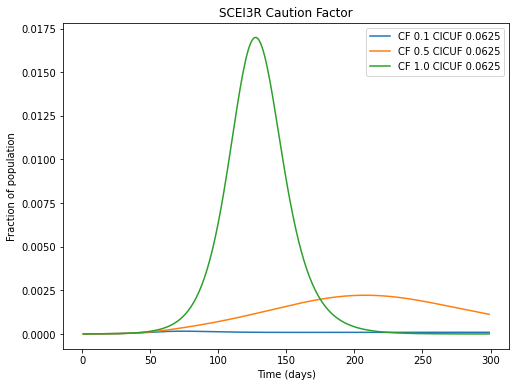

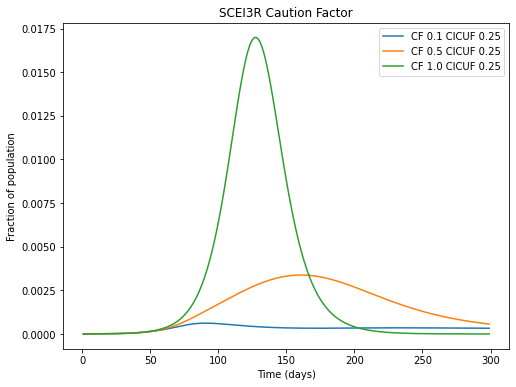

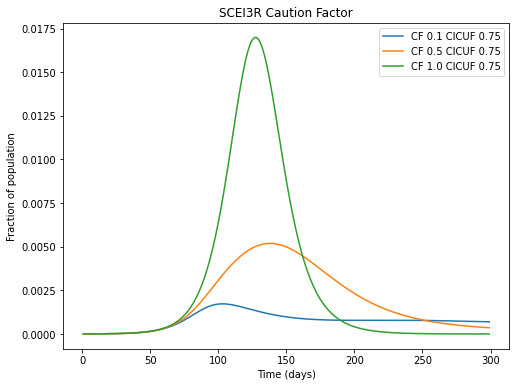

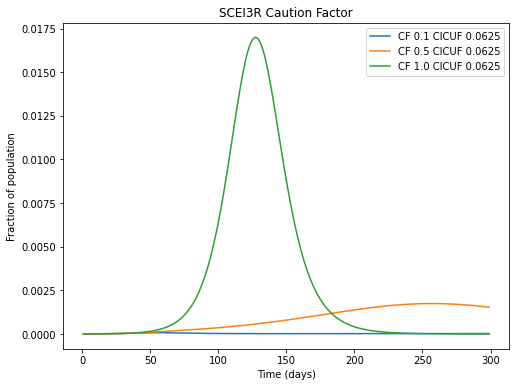

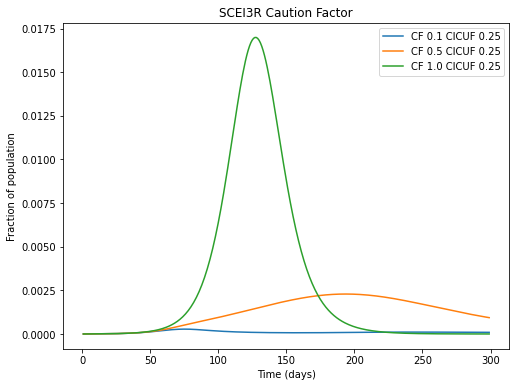

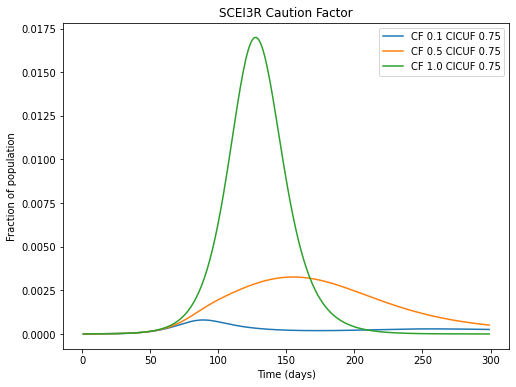

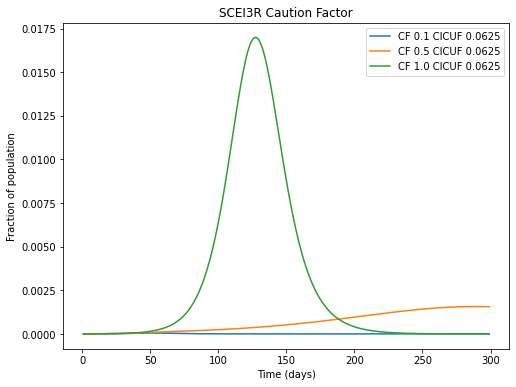

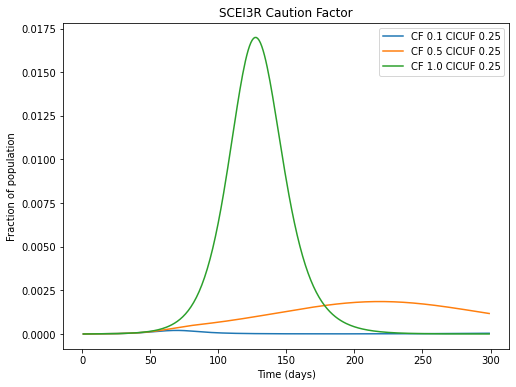

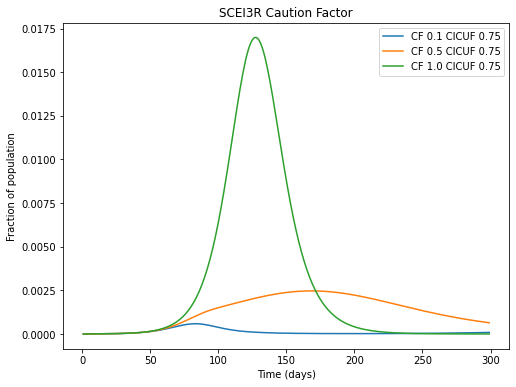

In [129]:
# more extensive parameter screen for one model
smodels = ['SCEI3R']
# tmax = lastday-1
tmax = 300
# caution standard parameters
CautionFactor= 0.2    # Fractional reduction of exposure rate for cautioned individuals
CautionRetention= 21. # Duration of cautionary state of susceptibles (4 weeks)
CautionICUFrac= 0.3   # Fraction of ICUs occupied leading to transition to caution @ 1/day 
ICUFrac= 0.002        # Fraction of ICUs relative to population size N

# Sensitivity scans
CautionFactors= [1.0,0.5,0.1]       # Fractional reduction of exposure rate for cautioned individuals
CautionRetentions= [7.,28.,112.]    # Duration of cautionary state of susceptibles (2 weeks)
CautionICUFracs= [0.0625,0.25,0.75] # Fraction of ICUs occupied leading to 90% of susceptibles in caution 

for s2 in range(3):
 newplot = True
 for s3 in range(3):
   newplot = True
   for s1 in range(3):
    for smodel in smodels:
        model = cmodels[smodel]
        if 'C' in model.modelname: 
            cmodels[smodel].parameters = {'c_0':CautionFactors[s1],'c_1':1./CautionRetentions[s2],'c_2':1./(N*ICUFrac*CautionICUFracs[s3])}
        else:
            print("ERROR")
    label_c = ('CF %s' % CautionFactors[s1]) + (' CICUF %s'% CautionICUFracs[s3])
    plottitle = 'Caution Factor' 
    solns=solveplot(smodels,'confirmed',tmax,'daily','daily',None,'linear',plottitle,label_c,newplot)
    plt.legend()
    newplot = False
    
# return parameters to standard set
for smodel in smodels:
    model = cmodels[smodel]
    if 'C' in model.modelname:
        cmodels[smodel].parameters = {'c_0':CautionFactor,'c_1':1./CautionRetention,'c_2':1./(N*ICUFrac*CautionICUFrac)}


In [130]:
# the parameters are stored not as strings but as sympy symbols
# but they cannot be accessed externally like that
# from sympy import Symbol
# cmodels['SCIR'].parameters[Symbol('c_0')]  # prouces KeyError: c_0
types= [type(k) for k in cmodels['SCIR'].parameters.keys()]
print(types)

[<class 'sympy.core.symbol.Symbol'>, <class 'sympy.core.symbol.Symbol'>, <class 'sympy.core.symbol.Symbol'>, <class 'sympy.core.symbol.Symbol'>, <class 'sympy.core.symbol.Symbol'>, <class 'sympy.core.symbol.Symbol'>, <class 'sympy.core.symbol.Symbol'>]


# Parameter fitting

## Fitting via sliders

### SC3EIR Model

In [63]:
len(t)

135

In [131]:
model = 'SC3EIR'
params={'beta':0.25,'alpha':1./5.,'gamma':0.1,'mu':0.05,'c_0':0.3, 'c_1':1/14., 'c_2':2000}
def slidefitplot(beta,alpha,gamma,mu,c_0,c_1,c_2,logI_0):
    params={ 'beta':beta, 'alpha':alpha, 'gamma':gamma, 'mu':mu, 'c_0':c_0, 'c_1':c_1, 'c_2':c_2}
    cmodels[model].parameters = params
    I0 = 10**logI_0
    x0 = [1.-I0,0.,I0,0.,0.,0.,0.,0.]
    cmodels[model].initial_values = (x0,t[0])
    solveplot(smodels=[model],species=['confirmed','recovered','deaths'],tmax=len(t),summing='daily',fitdata=y_jhu[test_country],scale='linear',plottitle= '',label='confirmed',newplot = True)

In [132]:
interact(slidefitplot,
         beta=FloatSlider(min=0,max=1,step=0.01,value=params['beta'],description='beta',
                            style=style,layout=slider_layout,continuous_update=False,readout_format='.3f'),
         alpha=FloatSlider(min=0,max=1,step=0.01,value=params['alpha'],description='alpha',
                            style=style,layout=slider_layout,continuous_update=False,readout_format='.3f'),
         gamma=FloatSlider(min=0,max=1,step=0.01,value=params['gamma'],description='gamma',
                            style=style,layout=slider_layout,continuous_update=False,readout_format='.3f'),
         mu=FloatSlider(min=0,max=0.1,step=0.001,value=params['mu'],description='mu',
                            style=style,layout=slider_layout,continuous_update=False,readout_format='.3f'),     
         c_0=FloatSlider(min=0,max=1,step=0.01,value=params['c_0'],description='c_0',
                            style=style,layout=slider_layout,continuous_update=False,readout_format='.3f'),
         c_1=FloatSlider(min=0,max=1,step=0.001,value=params['c_1'],description='c_1',
                            style=style,layout=slider_layout,continuous_update=False,readout_format='.3f'),
         c_2=FloatSlider(min=0,max=5000,step=1,value=params['c_2'],description='c_2',
                            style=style,layout=slider_layout,continuous_update=False,readout_format='.1f'),
         logI_0=FloatSlider(min=-10,max=0,step=0.01,value=-6,description='log I_0',
                            style=style,layout=slider_layout,continuous_update=False))

interactive(children=(FloatSlider(value=0.25, continuous_update=False, description='beta', layout=Layout(width…

<function __main__.slidefitplot(beta, alpha, gamma, mu, c_0, c_1, c_2, logI_0)>

### SC3EI3R Model

In [63]:
len(t)

135

In [198]:
(1.0/TimeICUDeath)*(CFR/FracCritical)

0.07142857142857142

In [209]:
model = 'SC3EI3R'

# Define parameters based on clinical observations Dr. Alison
Exposure=0.41 # Rate coefficient for exposure per individual in contact per day
IncubPeriod=5  #Incubation period, days
DurMildInf=10 #Duration of mild infections, days
FracMild=0.70  #Fraction of infections that are mild
FracSevere=0.20 #Fraction of infections that are severe
FracCritical=0.1 #Fraction of infections that are critical
CFR=0.05 #Case fatality rate (fraction of infections resulting in death)
TimeICUDeath=5 #Time from ICU admission to death, days
DurHosp=8 #Duration of hospitalization, days

# Model fitting extension to allow for incomplete detection
FracConfirmedDet=0.125  # Fraction of recovered individuals measured
FracRecoveredDet=FracConfirmedDet # Fraction of recovered individuals measured
FracDeathsDet=1.0

# Model extension by John McCaskill to include caution 
CautionFactor= 0.1 # Fractional reduction of exposure rate for cautioned individuals
CautionRetention= 33. # Duration of cautionary state of susceptibles (2 weeks)
CautionICUFrac= 0.1 # Fraction of ICUs occupied leading to transition to caution @ 1/day
ICUFrac= 0.001 # Fraction of ICUs relative to population size N

params = {'beta_1' : Exposure/sum(x0_SC3EI3R),
          'beta_2' : 0.0,
          'beta_3' : 0.0,
          'alpha' : 1.0/IncubPeriod,
          'gamma_1': (1.0/DurMildInf)*FracMild,
          'gamma_2': (1.0/DurHosp)-(1/DurHosp)*(FracCritical/(FracCritical+FracSevere)),
          'gamma_3': (1.0/TimeICUDeath)-(1/TimeICUDeath)*(CFR/FracCritical),
          'p_1'    : (1.0/DurMildInf)-(1.0/DurMildInf)*FracMild,
          'p_2'    : (1.0/DurHosp)*(FracCritical/(FracCritical+FracSevere)),
          'mu'    : (1.0/TimeICUDeath)*(CFR/FracCritical),
          'c_0'    : CautionFactor,
          'c_1'    : 1.0/CautionRetention,
          'c_2'    : 1.0/(sum(x0_SC3EI3R)*ICUFrac*CautionICUFrac),
          'N'     : sum(x0_SC3EI3R)}


def slidefitplot(beta_1,mu,c_0,c_1,c_2,logI_0):
    params={ 'beta_1':beta_1, 'mu':mu, 'c_0':c_0, 'c_1':c_1, 'c_2':c_2}
    cmodels[model].parameters = params
    I0 = 10**logI_0
    x0 = [1.-I0,0.,I0,0.,0.,0.,0.,0.,0.,0.]
    cmodels[model].initial_values = (x0,t[0])
    weights=np.array([2.,2.,1.])
    solveplot(smodels=[model],species=['confirmed','recovered','deaths_x10'],tmax=len(t),summing='daily',averaging='weekly',fitdata=y_jhu[test_country]*weights,scale='linear',plottitle= '',label='confirmed',newplot = True)

In [210]:
w =interactive(slidefitplot,
         beta_1=FloatSlider(min=0,max=1,step=0.01,value=params['beta_1'],description='beta_1',
                            style=style,layout=slider_layout,continuous_update=False,readout_format='.3f'),
         mu=FloatSlider(min=0,max=0.1,step=0.001,value=params['mu'],description='mu',
                            style=style,layout=slider_layout,continuous_update=False,readout_format='.3f'),     
         c_0=FloatSlider(min=0,max=1,step=0.01,value=params['c_0'],description='c_0',
                            style=style,layout=slider_layout,continuous_update=False,readout_format='.3f'),
         c_1=FloatSlider(min=0,max=1,step=0.001,value=params['c_1'],description='c_1',
                            style=style,layout=slider_layout,continuous_update=False,readout_format='.3f'),
         c_2=FloatSlider(min=0,max=20000,step=1,value=params['c_2'],description='c_2',
                            style=style,layout=slider_layout,continuous_update=False,readout_format='.1f'),
         logI_0=FloatSlider(min=-10,max=0,step=0.01,value=-6,description='log I_0',
                            style=style,layout=slider_layout,continuous_update=False))
display(w)

interactive(children=(FloatSlider(value=0.41, continuous_update=False, description='beta_1', layout=Layout(wid…

In [212]:
params=w.kwargs

print(params)

{'beta_1': 0.41, 'mu': 0.1, 'c_0': 0.07, 'c_1': 0.015, 'c_2': 11802.0, 'logI_0': -6.37}


## Testing fitting

### Generate test data based on SCEI3R simulation

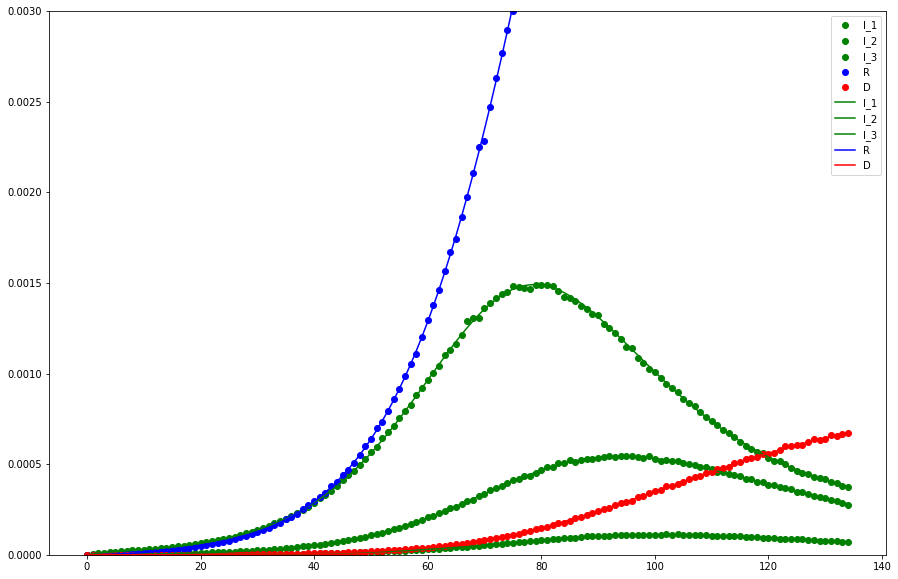

In [66]:
# Add noise
y = solution[:,2:7].copy()
#print('len(y)',len(y),'t',len(t),t[0],t[1],'...',t[-1])
np.random.seed(seed=6)
noise = np.random.normal(0,1.e-2,[len(t),5])
# ynoise = y *(1+noise)
ynoise = y *(1.0 + noise)
ynoise[ynoise<0] = 0
plt.figure(figsize=(15,10))
plt.plot(t,ynoise[:,0], 'go', label='I_1') 
plt.plot(t,ynoise[:,1], 'go', label='I_2') 
plt.plot(t,ynoise[:,2], 'go', label='I_3') 
plt.plot(t,ynoise[:,3], 'bo', label='R') 
plt.plot(t,ynoise[:,4], 'ro', label='D') 
plt.plot(t,y[:,0], 'g', label='I_1') 
plt.plot(t,y[:,1], 'g', label='I_2') 
plt.plot(t,y[:,2], 'g', label='I_3') 
plt.plot(t,y[:,3], 'b', label='R') 
plt.plot(t,y[:,4], 'r', label='D') 
plt.legend()
plt.ylim(0,0.003)
plt.show()

{'beta': 0.25, 'alpha': 0.2, 'gamma': 0.1, 'mu': 0.05, 'c_0': 0.3, 'c_1': 0.07142857142857142, 'c_2': 2000}
0.3 0.07142857142857142
[0.99997, 0.0, 3e-05, 0.0, 0.0, 0.0, 0.0, 0.0]
Peak infection (days) 85.0


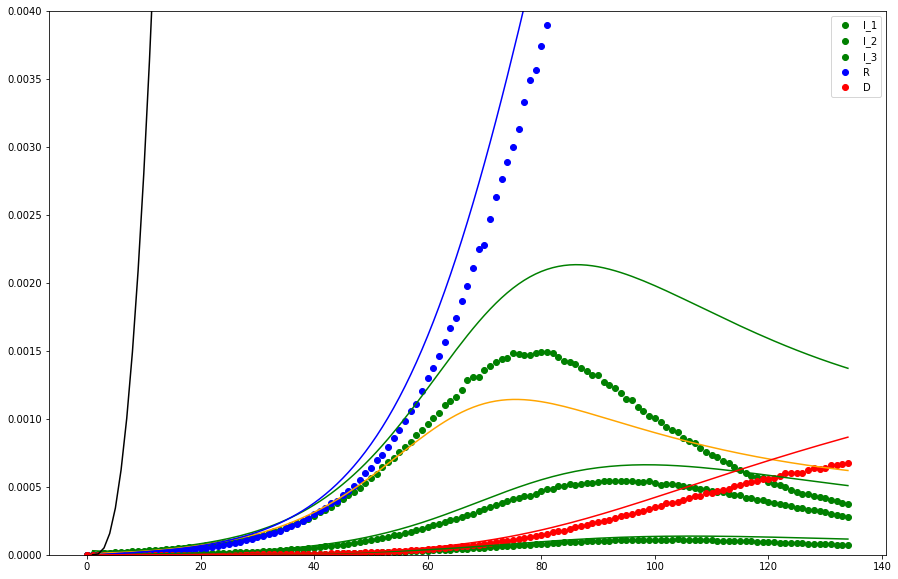

In [67]:
# model with generating parameters 
print(params)
params_fit = params.copy()
print(params_fit['c_0'],params_fit['c_1'])
SCEI3R_model.params = params_fit

x0_fit = x0_SCEI3R.copy()
print(x0_fit)
#t_fit = numpy.linspace(0, 150, 1000)

t_fit = t
SCEI3R_model.initial_values = (x0_fit, t_fit[0])
# %timeit sol_fit =SCEI3R_model.integrate(t_fit[1::]) # use magic %timeit to time
sol_fit = scipy.integrate.odeint(SCEI3R_model.ode, x0_fit, t_fit[1::])
# print(len(sol_fit[0]))
#
plt.figure(figsize=(15,10))
plt.plot(t,ynoise[:,0], 'go',label='I_1') # infected observations
plt.plot(t,ynoise[:,1], 'go',label='I_2') # infected observations
plt.plot(t,ynoise[:,2], 'go',label='I_3') # infected observations
plt.plot(t,ynoise[:,3], 'bo',label='R') # recoverd
plt.plot(t,ynoise[:,4], 'ro',label='D') # died
plt.gca().set_prop_cycle(color=['grey','orange','green','green','green','blue','red', 'black'])
plt.plot(t_fit[1::], sol_fit)
plt.ylim([0,0.004])
plt.legend()
#plt.show(())
#ode_fit.plot()

peak_i = np.argmax(sol_fit[:,2])
print('Peak infection (days)', t_fit[peak_i])

In [68]:
params # use list(...) to convert to list

{'beta': 0.25,
 'alpha': 0.2,
 'gamma': 0.1,
 'mu': 0.05,
 'c_0': 0.3,
 'c_1': 0.07142857142857142,
 'c_2': 2000}

### Fit parameters to randomized simulation data based on square_loss

#### Fit c_0 and c_1 only

In [69]:
# Initial guess of parameters, and bounding constraints
cautionparams = list(params.values())[-4:-2]
theta = [value for value in cautionparams]
theta = [0.21,0.08]
boxBounds = [(0.2,0.4),(0.05,0.15)]
objSCEI3R = SquareLoss(theta=theta, ode=SCEI3R_model, x0=x0_SCEI3R, t0=t[0], t=t[1::], y=ynoise[1::,:],
                      state_weight=[1.,1.,1.,1.0,1.0],state_name=['I_1','I_2','I_3','R','D'],
                      target_param=['c_0','c_1'])
# perform optimization
res = minimize(fun=objSCEI3R.cost,
                jac=objSCEI3R.sensitivity,
                x0=theta,
                #bounds=boxBounds,
                method='BFGS',
                options={'disp':True,'maxiter':1000,'eps':0.00001})# ,'ftol':0.01})  #not BFGS
print(res)

Optimization terminated successfully.
         Current function value: 0.000014
         Iterations: 3
         Function evaluations: 4
         Gradient evaluations: 4
      fun: 1.3747770699575006e-05
 hess_inv: array([[ 0.99582567, -0.03080012],
       [-0.03080012,  0.8273194 ]])
      jac: array([-6.01807008e-06,  4.06924720e-06])
  message: 'Optimization terminated successfully.'
     nfev: 4
      nit: 3
     njev: 4
   status: 0
  success: True
        x: array([0.19128053, 0.02517365])


#### Fit c_0 and c_1 as well as initial value of E

##### Fit c_0 and c_1 as well as initial value of E with 'SLSQP'
does not work well
note use of special methods IV for initial value fitting of target_state

In [70]:
# Initial guess of parameters and initial condition, and bounding constraints
cautionparams = list(params.values())[-4:-2]
theta = [0.25,0.08]
boxBounds = [(0.2,0.4),(0.05,0.15)]
objSCEI3R = SquareLoss(theta=theta, ode=SCEI3R_model, x0=x0_SCEI3R, t0=t[0], t=t[1::], y=ynoise[1::,:],
                      state_weight=[1.,1.,1.,1.,1.],state_name=['I_1','I_2','I_3','R','D'],
                      target_param=['c_0','c_1'],target_state=['E'])
# perform optimization
res = minimize(fun=objSCEI3R.costIV,
                jac=objSCEI3R.sensitivityIV,
                x0=theta+[0.00005],
                #bounds=boxBounds+[(0.0000001,0.001)],
                method='SLSQP',
                options={'disp':True,'maxiter':1000,'eps':0.01,'ftol':0.01})
print(res)

/usr/local/lib/python3.7/site-packages/scipy/integrate/_ode.py:1348: UserWarning: lsoda: Excess work done on this call (perhaps wrong Dfun type).
  self.messages.get(istate, unexpected_istate_msg)))


IntegrationError: Failed integration with x =  [ 7.13539077e+169 -7.13539077e+169 -1.06848609e+085 -4.61471861e+001
 -8.39917961e-003 -1.07757372e+002 -3.77220832e-004 -1.23991878e+087] and max/min eigenvalues of the jacobian is 3.648947852011838e+84 and -9.777326307993689e+83

##### Fit c_0 and c_1 as well as initial value of E with BFGS
works well:  no constraints and gtol not ftol

In [ ]:
# Initial guess of parameters and initial condition, and bounding constraints
cautionparams = list(params.values())[-4:-2]
theta = [0.25,0.08]
boxBounds = [(0.2,0.4),(0.05,0.15)]
objSCEI3R = SquareLoss(theta=theta, ode=SCEI3R_model, x0=x0_SCEI3R, t0=t[0], t=t[1::], y=ynoise[1::,:],
                      state_weight=[1.,1.,1.,1.,1.],state_name=['I_1','I_2','I_3','R','D'],
                      target_param=['c_0','c_1'],target_state=['E'])
# perform optimization
res = minimize(fun=objSCEI3R.costIV,
                jac=objSCEI3R.sensitivityIV,
                x0=theta+[0.00005],
                #bounds=boxBounds+[(0.0000001,0.001)],
                method='BFGS',
                options={'disp':True,'maxiter':1000,'eps':0.01,'gtol':0.01})
print(res)

In [ ]:
# model with fitted parameters 
print(params)
print(x0_SCEI3R)
params_fit = params.copy()
#params_fit['c_0'] = res.x[0]
#params_fit['c_1'] = res.x[1]

SCEI3R_model.params = params_fit
print(SCEI3R_model.params)
#ode_fit = common_models.SEI3R({'beta':res.x[0], 'gamma':res.x[1],'alpha':res.x[2]})
#x0_fit = [1-1.27e-6, 1.27e-6, 0]
x0_fit = x0.copy()
#x0_fit[2] = res.x[2]
#t_fit = numpy.linspace(0, 150, 1000)
t_fit = t
SCEI3R_model.initial_values = (x0_fit, t_fit[0])
# %timeit sol_fit =SCEI3R_model.integrate(t_fit[1::]) # use magic %timeit to time
# sol_fit =SCEI3R_model.integrate(t_fit[0::])
sol_fit = scipy.integrate.odeint(SCEI3R_model.ode, x0_fit, t_fit[1::])
#
plt.figure(figsize=(15,10))
plt.plot(t,ynoise[:,0], 'go') # infected observations
plt.plot(t,ynoise[:,1], 'go') # infected observations
plt.plot(t,ynoise[:,2], 'go') # infected observations
plt.plot(t,ynoise[:,3], 'bo') # recoverd
plt.plot(t,ynoise[:,4], 'ro') # died
plt.plot(t_fit[1::], sol_fit)
plt.ylim([0,0.004])
#plt.show(())
#ode_fit.plot()

peak_i = np.argmax(sol_fit[:,2])
print('Peak infection (days)', t_fit[peak_i])

##### Fit c_0 and c_1 as well as initial value of E using L-BFGS-B
this method does not work well

In [ ]:
# Initial guess of parameters and initial condition, and bounding constraints
cautionparams = list(params.values())[-4:-2]
theta = [0.25,0.08]
boxBounds = [(0.2,0.4),(0.05,0.15)]
objSCEI3R = SquareLoss(theta=theta, ode=SCEI3R_model, x0=x0_SCEI3R, t0=t[0], t=t[1::], y=ynoise[1::,:],
                      state_weight=[1.,1.,1.,1.,1.],state_name=['I_1','I_2','I_3','R','D'],
                      target_param=['c_0','c_1'],target_state=['E'])
# perform optimization
res = minimize(fun=objSCEI3R.costIV,
                jac=objSCEI3R.sensitivityIV,
                x0=theta+[0.00005],
                bounds=boxBounds+[(0.0000001,0.001)],
                method='L-BFGS-B',
                options={'disp':True,'maxiter':1000,'eps':0.0001,'ftol':0.001})
print(res)

In [ ]:
objSCEI3R.residual()

##### Fit c_0 and c_1 as well as initial value of E with Nelder-Mead
no use of Jacobian and no constraints

In [ ]:
# Initial guess of parameters and initial condition, and bounding constraints
cautionparams = list(params.values())[-4:-2]
theta = [0.25,0.08]
boxBounds = [(0.2,0.4),(0.05,0.15)]
objSCEI3R = SquareLoss(theta=theta, ode=SCEI3R_model, x0=x0_SCEI3R, t0=t[0], t=t[1::], y=ynoise[1::,:],
                      state_weight=[1.,1.,1.,1.,1.],state_name=['I_1','I_2','I_3','R','D'],
                      target_param=['c_0','c_1'],target_state=['E'])
# perform optimization
res = minimize(fun=objSCEI3R.costIV,
                #jac=objSCEI3R.sensitivityIV,
                x0=theta+[0.00005],
                #bounds=boxBounds+[(0.0000001,0.001)],
                method='Nelder-Mead',
                options={'disp':True,'maxiter':1000}) #,'eps':0.0001,'ftol':0.01}) #not NM
print(res)

In [ ]:
# model with fitted parameters 
print(params)
print(x0_SCEI3R)
params_fit = params.copy()
#params_fit['c_0'] = res.x[0]
#params_fit['c_1'] = res.x[1]

SCEI3R_model.params = params_fit
print(SCEI3R_model.params)
#ode_fit = common_models.SEI3R({'beta':res.x[0], 'gamma':res.x[1],'alpha':res.x[2]})
#x0_fit = [1-1.27e-6, 1.27e-6, 0]
x0_fit = x0_SCEI3R.copy()
#x0_fit[2] = res.x[2]
#t_fit = numpy.linspace(0, 150, 1000)
t_fit = t
SCEI3R_model.initial_values = (x0_fit, t_fit[0])
# %timeit sol_fit =SCEI3R_model.integrate(t_fit[1::]) # use magic %timeit to time
# sol_fit =SCEI3R_model.integrate(t_fit[0::])
sol_fit = scipy.integrate.odeint(SCEI3R_model.ode, x0_fit, t_fit[1::])
#
plt.figure(figsize=(15,10))
plt.plot(t,ynoise[:,0], 'go') # infected observations
plt.plot(t,ynoise[:,1], 'go') # infected observations
plt.plot(t,ynoise[:,2], 'go') # infected observations
plt.plot(t,ynoise[:,3], 'bo') # recoverd
plt.plot(t,ynoise[:,4], 'ro') # died
plt.plot(t_fit[1::], sol_fit)
plt.ylim([0,0.004])
#plt.show(())
#ode_fit.plot()

peak_i = np.argmax(sol_fit[:,2])
print('Peak infection (days)', t_fit[peak_i])

## Fit SC2IR parameters to jhu data based on square_loss

In [ ]:
params=SC2IR_model.parameters
print(params)

In [ ]:
# Initial guess of parameters and initial condition, and bounding constraints
theta = [0.4,0.11,0.007,0.33,0.228,275.]
boxBounds = [(0.2,0.5),(0.05,0.15),(0.005,0.015),(0.25,0.55),(0.15,0.4),(5.,2000.)]
# setup cost function and Jacobian with target parameters and initial states
objSC2IR = SquareLoss(theta=theta, ode=SC2IR_model, x0=x0, t0=t[0], t=t[1::], y=y_jhu[test_country][1::,1:3],
                      state_weight=[0.2,1.],state_name=['R','D'],
                      target_param=['beta','gamma','mu','c_0','c_1','c_2'],
                      target_state=['I'])
# perform optimization
res = minimize(fun=objSC2IR.costIV,
                jac=objSC2IR.sensitivityIV,
                x0=theta+[0.000000001],
                bounds=boxBounds+[(0.0000000001,0.000001)],
                # method='L-BFGS-B',
                # method='Nelder-Mead',
                #options={'disp':True,'maxiter':1000,'eps':0.01,'gtol':0.01})
                options={'disp':True,'maxiter':1000,'eps':0.000001,'ftol':0.000000001})
print(res)

In [ ]:
# model with fitted parameters 
startparams = SC2IR_model.parameters.copy()  # save starting parameters (not fit)
print(params)
print(x0)
params_fit = params.copy()
params_fit['beta'] = res.x[0]
params_fit['gamma'] = res.x[1]
params_fit['mu'] = res.x[2]
params_fit['c_0'] = res.x[3]
params_fit['c_1'] = res.x[4]
params_fit['c_2'] = res.x[5]

SC2IR_model.params = params_fit
print(SC2IR_model.params)
x0_fit = x0.copy()
x0_fit[1] = res.x[6]
t_fit = t
SC2IR_model.initial_values = (x0_fit, t_fit[0])
sol_fit = scipy.integrate.odeint(SC2IR_model.ode, x0_fit, t_fit[1::])
#
plt.figure(figsize=(15,10))
plt.semilogy()
plt.ylim([0.000001,1])
plt.plot(t,y_jhu[test_country][:,1], 'bo',label='R')  # recovered
plt.semilogy()
plt.ylim([0.000001,1])
plt.plot(t,y_jhu[test_country][:,2], 'ro',label='D')  # died
plt.semilogy()
plt.ylim([0.000001,1])

plt.gca().set_prop_cycle(color=['grey','green','blue','red', 'black'])
plt.plot(t_fit[1::], sol_fit)
plt.ylim([0.000001,1])
plt.legend(('R','D','S','I','R','D','S_c','I_c'))
plt.semilogy()
#plt.show(())
#ode_fit.plot()

peak_i = np.argmax(sol_fit[:,1])
print('Peak infection (days)', t_fit[peak_i])
SC2IR_model.parameters = startparams

## Fit SC3EI3R parameters to jhu data based on square_loss

### Fit c_0 and c_1 only

In [ ]:
# Initial guess of parameters, and bounding constraints
cautionparams = list(params.values())[-4:-1]
theta = [value for value in cautionparams]
print(theta)
theta = [0.3,0.08,2500.]
boxBounds = [(0.2,0.8),(0.05,0.15),(100.,10000.)]
objSC3EI3R = SquareLoss(theta=theta, ode=SC3EI3R_model, x0=x0_SC3EI3R, t0=t[0], t=t[1::], y=y_jhu[test_country][1::,1:3],
                      state_weight=[1.,1.],state_name=['R','D'],
                      target_param=['c_0','c_1','c_2'])
# perform optimization
res = minimize(fun=objSC3EI3R.cost,
                #jac=objSC3EI3R.sensitivity,
                x0=theta,
                #bounds=boxBounds,
                method='L-BFGS-B',
                # method='Nelder-Mead',
                options={'disp':True,'maxiter':1000,'eps':0.00001})# ,'ftol':0.01})  #not BFGS
print(res)

### Fit c_0 and c_1 as well as initial value of E

#### Fit c_0 and c_1 as well as initial value of E with 'SLSQP'
does not work well
note use of special methods IV for initial value fitting of target_state

In [ ]:
# Initial guess of parameters and initial condition, and bounding constraints
cautionparams = list(params.values())[-4:-3]
theta = [value for value in cautionparams]
theta = [0.21,0.08,2500.]
objSC3EI3R = SquareLoss(theta=theta, ode=SC3EI3R_model, x0=x0_SC3EI3R, t0=t[0], t=t[1::], y=y_jhu[test_country][1::,1:3],
                      state_weight=[1.,1.],state_name=['R','D'],
                      target_param=['c_0','c_1','c_2'],target_state=['I_1'])
# perform optimization
res = minimize(fun=objSC3EI3R.costIV,
                jac=objSC3EI3R.sensitivityIV,
                x0=theta+[0.00005],
                bounds=boxBounds+[(0.0000001,0.001)],
                # method='BFGS',
                method='L-BFGS-B',
                options={'disp':True,'maxiter':1000,'eps':0.01,'gtol':0.01})
print(res)

#### Fit c_0 and c_1 as well as initial value of E with BFGS
works well:  no constraints and gtol not ftol

In [ ]:
# Initial guess of parameters and initial condition, and bounding constraints
cautionparams = list(params.values())[-4:-2]
theta = [0.25,0.08]
boxBounds = [(0.2,0.4),(0.05,0.15)]
objSCEI3R = SquareLoss(theta=theta, ode=SCEI3R_model, x0=x0_SC3EI3R, t0=t[0], t=t[1::], y=ynoise[1::,:],
                      state_weight=[1.,1.,1.,1.,1.],state_name=['I_1','I_2','I_3','R','D'],
                      target_param=['c_0','c_1'],target_state=['E'])
# perform optimization
res = minimize(fun=objSCEI3R.costIV,
                jac=objSCEI3R.sensitivityIV,
                x0=theta+[0.00005],
                #bounds=boxBounds+[(0.0000001,0.001)],
                method='BFGS',
                options={'disp':True,'maxiter':1000,'eps':0.01,'gtol':0.01})
print(res)

In [ ]:
# model with fitted parameters 
print(params)
print(x0_SC3EI3R)
params_fit = params.copy()
#params_fit['c_0'] = res.x[0]
#params_fit['c_1'] = res.x[1]

SC3EI3R_model.params = params_fit
print(SC3EI3R_model.params)
#ode_fit = common_models.SEI3R({'beta':res.x[0], 'gamma':res.x[1],'alpha':res.x[2]})
#x0_fit = [1-1.27e-6, 1.27e-6, 0]
x0_fit = x0_SC3EI3R.copy()
#x0_fit[2] = res.x[2]
#t_fit = numpy.linspace(0, 150, 1000)
t_fit = t
SC3EI3R_model.initial_values = (x0_fit, t_fit[0])
# %timeit sol_fit =SCEI3R_model.integrate(t_fit[1::]) # use magic %timeit to time
# sol_fit =SCEI3R_model.integrate(t_fit[0::])
sol_fit = scipy.integrate.odeint(SC3EI3R_model.ode, x0_fit, t_fit[1::])
#
plt.figure(figsize=(15,10))
plt.plot(t,ynoise[:,0], 'o',color='lightgreen') # infected observations
plt.plot(t,ynoise[:,1], 'o',color='green') # infected observations
plt.plot(t,ynoise[:,2], 'o',color='darkgreen') # infected observations
plt.plot(t,ynoise[:,3], 'bo') # recoverd
plt.plot(t,ynoise[:,4], 'ro') # died
plt.plot(t_fit[1::], sol_fit)
plt.ylim([0,0.004])
#plt.show(())
#ode_fit.plot()

peak_i = np.argmax(sol_fit[:,2])
print('Peak infection (days)', t_fit[peak_i])

#### Fit c_0 and c_1 as well as initial value of E using L-BFGS-B
this method does not work well

In [ ]:
# Initial guess of parameters and initial condition, and bounding constraints
cautionparams = list(params.values())[-4:-2]
theta = [0.25,0.08]
boxBounds = [(0.2,0.4),(0.05,0.15)]
objSCEI3R = SquareLoss(theta=theta, ode=SCEI3R_model, x0=x0_SC3EI3R, t0=t[0], t=t[1::], y=ynoise[1::,:],
                      state_weight=[1.,1.,1.,1.,1.],state_name=['I_1','I_2','I_3','R','D'],
                      target_param=['c_0','c_1'],target_state=['E'])
# perform optimization
res = minimize(fun=objSCEI3R.costIV,
                jac=objSCEI3R.sensitivityIV,
                x0=theta+[0.00005],
                bounds=boxBounds+[(0.0000001,0.001)],
                method='L-BFGS-B',
                options={'disp':True,'maxiter':1000,'eps':0.0001,'ftol':0.001})
print(res)

In [ ]:
objSCEI3R.residual()

#### Fit c_0 and c_1 as well as initial value of E with Nelder-Mead
no use of Jacobian and no constraints

In [ ]:
# Initial guess of parameters and initial condition, and bounding constraints
cautionparams = list(params.values())[-4:-2]
theta = [0.25,0.08]
boxBounds = [(0.2,0.4),(0.05,0.15)]
objSCEI3R = SquareLoss(theta=theta, ode=SCEI3R_model, x0=x0_SC3EI3R, t0=t[0], t=t[1::], y=ynoise[1::,:],
                      state_weight=[1.,1.,1.,1.,1.],state_name=['I_1','I_2','I_3','R','D'],
                      target_param=['c_0','c_1'],target_state=['E'])
# perform optimization
res = minimize(fun=objSCEI3R.costIV,
                #jac=objSCEI3R.sensitivityIV,
                x0=theta+[0.00005],
                #bounds=boxBounds+[(0.0000001,0.001)],
                method='Nelder-Mead',
                options={'disp':True,'maxiter':1000}) #,'eps':0.0001,'ftol':0.01}) #not NM
print(res)

In [ ]:
# model with fitted parameters 
print(params)
print(x0_SC3EI3R)
params_fit = params.copy()
params_fit['c_0'] = res.x[0]
params_fit['c_1'] = res.x[1]

SC3EI3R_model.params = params_fit
print(SC3EI3R_model.params)
x0_fit = x0_SC3EI3R.copy()
#x0_fit[2] = res.x[2]
#t_fit = numpy.linspace(0, 150, 1000)
t_fit = t
SC3EI3R_model.initial_values = (x0_fit, t_fit[0])
# %timeit sol_fit =SC3EI3R_model.integrate(t_fit[1::]) # use magic %timeit to time
# sol_fit =SC3EI3R_model.integrate(t_fit[0::])
sol_fit = scipy.integrate.odeint(SC3EI3R_model.ode, x0_fit, t_fit[1::])
#
plt.figure(figsize=(15,10))
plt.plot(t,y_jhu[:,0], 'bo') # recoverd
plt.plot(t,y_jhu[:,1], 'ro') # died
plt.plot(t_fit[1::], sol_fit)
plt.ylim([0,0.004])
#plt.show(())
#ode_fit.plot()

peak_i = np.argmax(sol_fit[:,2])
print('Peak infection (days)', t_fit[peak_i])

### Information on method options

In [ ]:
scipy.optimize.show_options(solver='minimize', method='SLSQP', disp=True)
print(' ')
scipy.optimize.show_options(solver='minimize', method='L-BFGS-B', disp=True)

## Plot using full control

In [ ]:
def plotmodel(solns,t,scale='linear',species='no_susc',plottitle= '',label='',
              newplot = True,models=['SEI3R','SCEI3R','SC3EI3R']):
    """
    plot solns over 
    times t interpreted as models indicated in models parameter
    scale: alternative 'linear' or 'log'
    species alternatives 'all', 'confirmed', 'deaths', 'daily confirmed', 'daily deaths'
    plottitle : title for plot
    label : label for curve when called as part of multicurve plot
    newplot : whether to open new plot True/False
    models : list of models to include, default all three of those possible
    """
   
    nmodels = len(models)
    if len(solns) != len(models):
        print("Error: number of models must match number of solutions")
        return None
    nm = 0
    
    if newplot == True:
        plt.figure(figsize=(nmodels*8,6))
 
    for nm in range(nmodels):
        soln = solns[nm]
        if models[nm] == 'SEI3R':   #SEI3R
            plt.subplot(1,nmodels,nm+1)
            if scale == 'log': #Plot on log scale
                plt.semilogy()
                plt.ylim([1,10000])
            elif species != 'daily confirmed': # Plot on normal linear scale
                #plt.ylim([0,10000])
                pass
            if species == 'no_susc':
                plt.plot(tvec,soln[:,1:5],label=label)
                plt.legend(("E","I1","I2","I3"))
            elif species == 'confirmed' or species == 'daily confirmed':
                suma = np.sum(soln[:,2:7],axis=1)
                # print('length=',len(suma))
                if species == 'daily confirmed':
                    sumd = np.zeros(len(suma))
                    for i in range(1,len(suma)):
                        sumd[i] = suma[i]-suma[i-1]
                    #plt.ylim([0,1000])
                    plt.plot(tvec,sumd,label=label)
                else:
                    #plt.ylim([0,200000])
                     plt.plot(t,suma,label=label)                   
            elif species == 'all':
                plt.plot(tvec,soln,label=label)
                plt.legend(("S","E","I1","I2","I3","R","D"))
            plt.xlabel("Time (days)")
            plt.ylabel("Portion of population N")
            plt.title('SEI3R %s' % plottitle)

        elif models[nm] == 'SCEI3R':   #SCEI3R
            #Plot
            plt.subplot(1,nmodels,nm+1)
            if scale == 'log': #Plot on log scale
                plt.semilogy()
                plt.ylim([1,10000])
            elif species != 'daily confirmed': # Plot on normal linear scale
                #plt.ylim([0,10000])
                pass
            if species == 'no_susc':
                plt.plot(t,soln[:,1:5],label=label)
                plt.legend(("E","I1","I2","I3"))
            elif species == 'confirmed' or species == 'daily confirmed':
                suma = np.sum(soln[:,2:7],axis=1)
                # print('length=',len(suma))
                if species == 'daily confirmed':
                    sumd = np.zeros(len(suma))
                    for i in range(1,len(suma)):
                        sumd[i] = suma[i]-suma[i-1]
                    #plt.ylim([0,1000])
                    plt.plot(t,sumd,label=label)
                else:
                    #plt.ylim([0,200000])
                    plt.plot(t,suma,label=label)
            elif species == 'all':
                plt.plot(t,soln,label=label)
                plt.legend(("S","E","I1","I2","I3","R","D","Sc"))
            plt.xlabel("Time (days)")
            plt.ylabel("Portion of population N")
            plt.title('SCEI3R %s' % plottitle)
        elif models[nm] == 'SC3EI3R':   #SC3EI3R
            plt.subplot(1,nmodels,nm+1)
            if scale == 'log': #Plot on log scale
                plt.semilogy()
                plt.ylim([1,10000])
            elif species != 'daily confirmed': # Plot on normal linear scale
                #plt.ylim([0,10000])
                pass
            if species == 'no_susc':
                plt.plot(t,sol[:,1:5])
                plt.legend(("E","I1","I2","I3"))
            elif species == 'confirmed' or species == 'daily confirmed':
                suma = np.sum(soln[:,2:7],axis=1) + soln[:,9]
                if species == 'daily confirmed':
                    sumd = np.zeros(len(suma))
                    for i in range(1,len(suma)):
                        sumd[i] = suma[i]-suma[i-1]
                    # plt.ylim([0,1000])
                    plt.plot(t,sumd,label=label)
                else:
                    # plt.ylim([0,200000])
                    plt.plot(t,suma,label=label)
            elif species == 'all':
                plt.plot(t,soln,label=label)
                plt.legend(("S","E","I1","I2","I3","R","D","Sc","Ec","I1c"))
            plt.xlabel("Time (days)")
            plt.ylabel("Portion of population N")
            plt.title('SC3EI3R %s' % plottitle)
    return True

In [ ]:
plotmodel([sol_fit],t_fit[1:],scale='linear',species='no_susc',plottitle= 'test',label='',
              newplot = True,models=['SCEI3R'])

# Not yet implemented

In [ ]:
# R0 from arXiv paper
# does not work yet properly ! reason unclear
from pygom.model.epi_analysis import R0
ode1 = SCEI3R_model.ode
ode2 = SimulateOde(state, param_list, transition=transition)
# print(ode2)
# ode = ode2.get_unrolled_obj() # Exception: Object was not initialized using a set of ode
# so need to define model via odes for this to work?
# R0( ode2, ['I_1','I_2','I_3'])

In [ ]:
# function for altering parameters
print(param_list) 
model = DeterministicOde(state, param_list, transition=transition)
def parameterize_model(t=np.linspace(0,365,366), c_0=0.3, c_1=0.07,
                       c_2=0.004,I1_init=0.00001, default_params = param_list, model=model):
    ic=[1-I1_init, I1_init, 0, 0, 0, 0, 0, 0]
    cautionparams = {'c_0': c_0,
              'c_1': c_1, 
              'c_2': c_2,
              'N': sum(ic)}
    
    model.initial_values = (ic, t[0])
    model.parameters = params
    sol = model.integrate(t[1::])
    model.plot()
    peak_i = np.argmax(sol[:,2])
    print('Peak infection (days)', t[peak_i] )
    

In this simple framework, reducing $\beta$ results in a smaller epidemic:
- the peak infection time is delayed
- the magnitude of peak infection is reduced.

Reducing beta may crudely represent giving out anti-virals, which make a person less infectious.

In [ ]:
parameterize_model(beta=1.2, t=np.linspace(0,500,5001))

Vaccinating 5% of the population (assuming instantaneous rollout) or natural immunity, delays the peak period, and reduces its magnitude.

In [ ]:
parameterize_model(ic=[9490,5, 5, 500], beta=0.5, gamma=0.3, t=np.linspace(0,150,10))

# gompy test example for FitzHugh model

In [ ]:
from unittest import main, TestCase

import numpy as np
from scipy.optimize import minimize

from pygom import SquareLoss
from pygom.model import common_models


class TestFHEstimate(TestCase):

    def setUp(self):
        # initial values
        x0 = [-1.0, 1.0]
        # params
        param_eval = [('a', 0.2), ('b', 0.2), ('c', 3.0)]
        self.target = np.array([0.2, 0.2, 3.0])
        # the time points for our observations
        t = np.linspace(0, 20, 30).astype('float64')
        ode = common_models.FitzHugh(param_eval)
        ode.initial_values = (x0, t[0])
        solution = ode.integrate(t[1::])
        self.theta = np.array([0.5, 0.5, 0.5])

        self.obj = SquareLoss(self.theta, ode, x0, t[0],
                              t[1::], solution[1::, :], ['V', 'R'])

        g = self.obj.gradient()
        assert np.linalg.norm(g) > 0

        EPSILON = np.sqrt(np.finfo(np.float).eps)

        self.box_bounds = [(EPSILON, 5.0)]*len(self.theta)

    def test_FH_sensitivity(self):
        res = minimize(fun=self.obj.cost,
                       jac=self.obj.sensitivity,
                       x0=self.theta,
                       bounds=self.box_bounds,
                       method='L-BFGS-B')

        self.assertTrue(np.allclose(self.target, res['x'], 1e-2, 1e-2))

    def test_FH_adjoint(self):
        res = minimize(fun=self.obj.cost,
                       jac=self.obj.adjoint,
                       x0=self.theta,
                       bounds=self.box_bounds,
                       method='L-BFGS-B')

        self.assertTrue(np.allclose(self.target, res['x'], 1e-2, 1e-2))

    def test_FH_IV(self):
        box_bounds = self.box_bounds + [(None, None)]*2

        res = minimize(fun=self.obj.costIV,
                       jac=self.obj.sensitivityIV,
                       x0=self.theta.tolist() + [-0.5, 0.5],
                       bounds=box_bounds,
                       method='L-BFGS-B')

        target = np.array([0.2, 0.2, 3.0, -1.0, 1.0])
        self.assertTrue(np.allclose(res['x'], target, 1e-2, 1e-2))

In [ ]:
test=TestFHEstimate()

In [ ]:
test.setUp()

In [ ]:
test.test_FH_IV()